In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats as scipy_stats
import warnings
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')


# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# 1. CARGA Y PREPARACI√ìN DE DATOS

In [3]:
print("="*80)
print("PASO 1: EXPLORACI√ìN Y VISUALIZACI√ìN INICIAL")
print("="*80)

df = pd.read_csv('data/sample_temporal.csv')

print("\nPrimeras filas del dataset:")
print(df.head())


PASO 1: EXPLORACI√ìN Y VISUALIZACI√ìN INICIAL

Primeras filas del dataset:
       Ticker              ADA-USD            ADA-USD.1            ADA-USD.2  \
0       Price                 Open                 High                  Low   
1        Date                  NaN                  NaN                  NaN   
2  2020-10-15  0.10721699893474579  0.10759100317955017   0.1049790009856224   
3  2020-10-16  0.10674799978733063   0.1073170006275177  0.10253699868917465   
4  2020-10-17   0.1042179986834526  0.10697899758815765  0.10336600244045258   

             ADA-USD.3  ADA-USD.4            ETH-USD           ETH-USD.1  \
0                Close     Volume               Open                High   
1                  NaN        NaN                NaN                 NaN   
2  0.10663499683141708  562197282  379.1922302246094   381.2087707519531   
3  0.10406400263309479  553561875  377.8684997558594   380.0215148925781   
4  0.10610400140285492  472005227  366.0157165527344  369.768127

In [4]:
# Informaci√≥n general
print("\nInformaci√≥n del dataset:")
print(df.info())

# Identificar las columnas de cada criptomoneda
print("\nColumnas disponibles:")
print(df.columns.tolist())


Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ticker      1829 non-null   object
 1   ADA-USD     1828 non-null   object
 2   ADA-USD.1   1828 non-null   object
 3   ADA-USD.2   1828 non-null   object
 4   ADA-USD.3   1828 non-null   object
 5   ADA-USD.4   1828 non-null   object
 6   ETH-USD     1828 non-null   object
 7   ETH-USD.1   1828 non-null   object
 8   ETH-USD.2   1828 non-null   object
 9   ETH-USD.3   1828 non-null   object
 10  ETH-USD.4   1828 non-null   object
 11  BTC-USD     1828 non-null   object
 12  BTC-USD.1   1828 non-null   object
 13  BTC-USD.2   1828 non-null   object
 14  BTC-USD.3   1828 non-null   object
 15  BTC-USD.4   1828 non-null   object
 16  DOGE-USD    1828 non-null   object
 17  DOGE-USD.1  1828 non-null   object
 18  DOGE-USD.2  1828 non-null   object
 19  DOGE-USD.3  1828 non-

 # 2. PREPARAR DATOS POR CRIPTOMONEDA

In [5]:
print("\nEstructura del archivo detectada:")
print(f"   - Filas: {len(df)}")
print(f"   - Columnas: {len(df.columns)}")


Estructura del archivo detectada:
   - Filas: 1829
   - Columnas: 26


In [6]:
# Eliminar las primeras 2 filas que son headers
df_clean = df.iloc[1:].reset_index(drop=True)

In [7]:
# La columna 'Ticker' contiene las fechas
df_clean['Date'] = pd.to_datetime(df_clean['Ticker'], errors='coerce')

In [8]:
# Identificar las criptomonedas disponibles
cryptos = ['BTC-USD', 'ETH-USD', 'DOGE-USD', 'ADA-USD', 'XRP-USD']

In [9]:
crypto_data = {}

for crypto in cryptos:
    # Buscar las columnas correspondientes a esta crypto
    # Formato: crypto, crypto.1, crypto.2, crypto.3, crypto.4
    # Corresponden a: Open, High, Low, Close, Volume
    
    base_col = crypto
    col_1 = f"{crypto}.1"
    col_2 = f"{crypto}.2"
    col_3 = f"{crypto}.3"
    col_4 = f"{crypto}.4"
    
    if all(col in df_clean.columns for col in [base_col, col_1, col_2, col_3, col_4]):
        # Crear DataFrame para esta crypto
        temp_df = pd.DataFrame({
            'Date': df_clean['Date'],
            'Open': pd.to_numeric(df_clean[base_col], errors='coerce'),
            'High': pd.to_numeric(df_clean[col_1], errors='coerce'),
            'Low': pd.to_numeric(df_clean[col_2], errors='coerce'),
            'Close': pd.to_numeric(df_clean[col_3], errors='coerce'),
            'Volume': pd.to_numeric(df_clean[col_4], errors='coerce')
        })
        
        # Eliminar filas con NaN
        temp_df = temp_df.dropna()
        
        # Ordenar por fecha
        temp_df = temp_df.sort_values('Date').reset_index(drop=True)
        
        crypto_data[crypto] = temp_df
        
        print(f"\n {crypto}: {len(temp_df)} observaciones")
        print(f"   Per√≠odo: {temp_df['Date'].min().strftime('%Y-%m-%d')} a {temp_df['Date'].max().strftime('%Y-%m-%d')}")


 BTC-USD: 1827 observaciones
   Per√≠odo: 2020-10-15 a 2025-10-15

 ETH-USD: 1827 observaciones
   Per√≠odo: 2020-10-15 a 2025-10-15

 DOGE-USD: 1827 observaciones
   Per√≠odo: 2020-10-15 a 2025-10-15

 ADA-USD: 1827 observaciones
   Per√≠odo: 2020-10-15 a 2025-10-15

 XRP-USD: 1827 observaciones
   Per√≠odo: 2020-10-15 a 2025-10-15


# 3. ESTAD√çSTICAS DESCRIPTIVAS

In [10]:
print("\n" + "="*80)
print(" ESTAD√çSTICAS DESCRIPTIVAS - PRECIOS DE CIERRE")
print("="*80)

stats_summary = []

for crypto, data in crypto_data.items():
    close_prices = data['Close']
    
    # Calcular returns simples para estad√≠sticas preliminares
    returns = close_prices.pct_change().dropna() * 100
    
    stats = {
        'Crypto': crypto,
        'Obs': len(data),
        'Precio_Promedio': f"${close_prices.mean():,.2f}",
        'Precio_Min': f"${close_prices.min():,.2f}",
        'Precio_Max': f"${close_prices.max():,.2f}",
        'Desv_Std': f"${close_prices.std():,.2f}",
        'Coef_Var_%': f"{(close_prices.std() / close_prices.mean()) * 100:.2f}%",
        'Return_Avg_%': f"{returns.mean():.4f}%",
        'Volatilidad_%': f"{returns.std():.4f}%",
        'Cambio_Total_%': f"{((close_prices.iloc[-1] - close_prices.iloc[0]) / close_prices.iloc[0]) * 100:.2f}%"
    }
    
    stats_summary.append(stats)


stats_df = pd.DataFrame(stats_summary)
print("\n")
print(stats_df.to_string(index=False))


 ESTAD√çSTICAS DESCRIPTIVAS - PRECIOS DE CIERRE


  Crypto  Obs Precio_Promedio Precio_Min  Precio_Max   Desv_Std Coef_Var_% Return_Avg_% Volatilidad_% Cambio_Total_%
 BTC-USD 1827      $51,107.61 $11,322.12 $124,752.53 $28,936.75     56.62%      0.1722%       3.1098%        860.63%
 ETH-USD 1827       $2,417.32    $366.23   $4,831.35    $980.02     40.54%      0.2149%       4.1602%        944.83%
DOGE-USD 1827           $0.14      $0.00       $0.68      $0.10     69.12%      0.5666%      10.8344%       7509.33%
 ADA-USD 1827           $0.73      $0.09       $2.97      $0.53     72.48%      0.2340%       5.2858%        525.90%
 XRP-USD 1827           $0.95      $0.21       $3.56      $0.79     83.73%      0.2827%       5.7859%        883.59%



1. DOGE-USD: Ha sido la inversi√≥n m√°s rentable del grupo por un margen enorme, pero tambi√©n la m√°s arriesgada y vol√°til. Su comportamiento es el de un activo altamente especulativo.
2. Los de "Alto Riesgo": XRP y Cardano (ADA): Son activos muy vol√°tiles y de alto riesgo, aunque no llegaron al extremo de DOGE en t√©rminos de rendimiento o volatilidad diaria.
3. Los "Gigantes" m√°s Consolidados: Bitcoin (BTC) y Ethereum (ETH):Activos m√°s "maduros" y (relativamente) menos vol√°tiles.

# 4. VISUALIZACI√ìN: PRECIOS HIST√ìRICOS


GENERANDO VISUALIZACIONES...


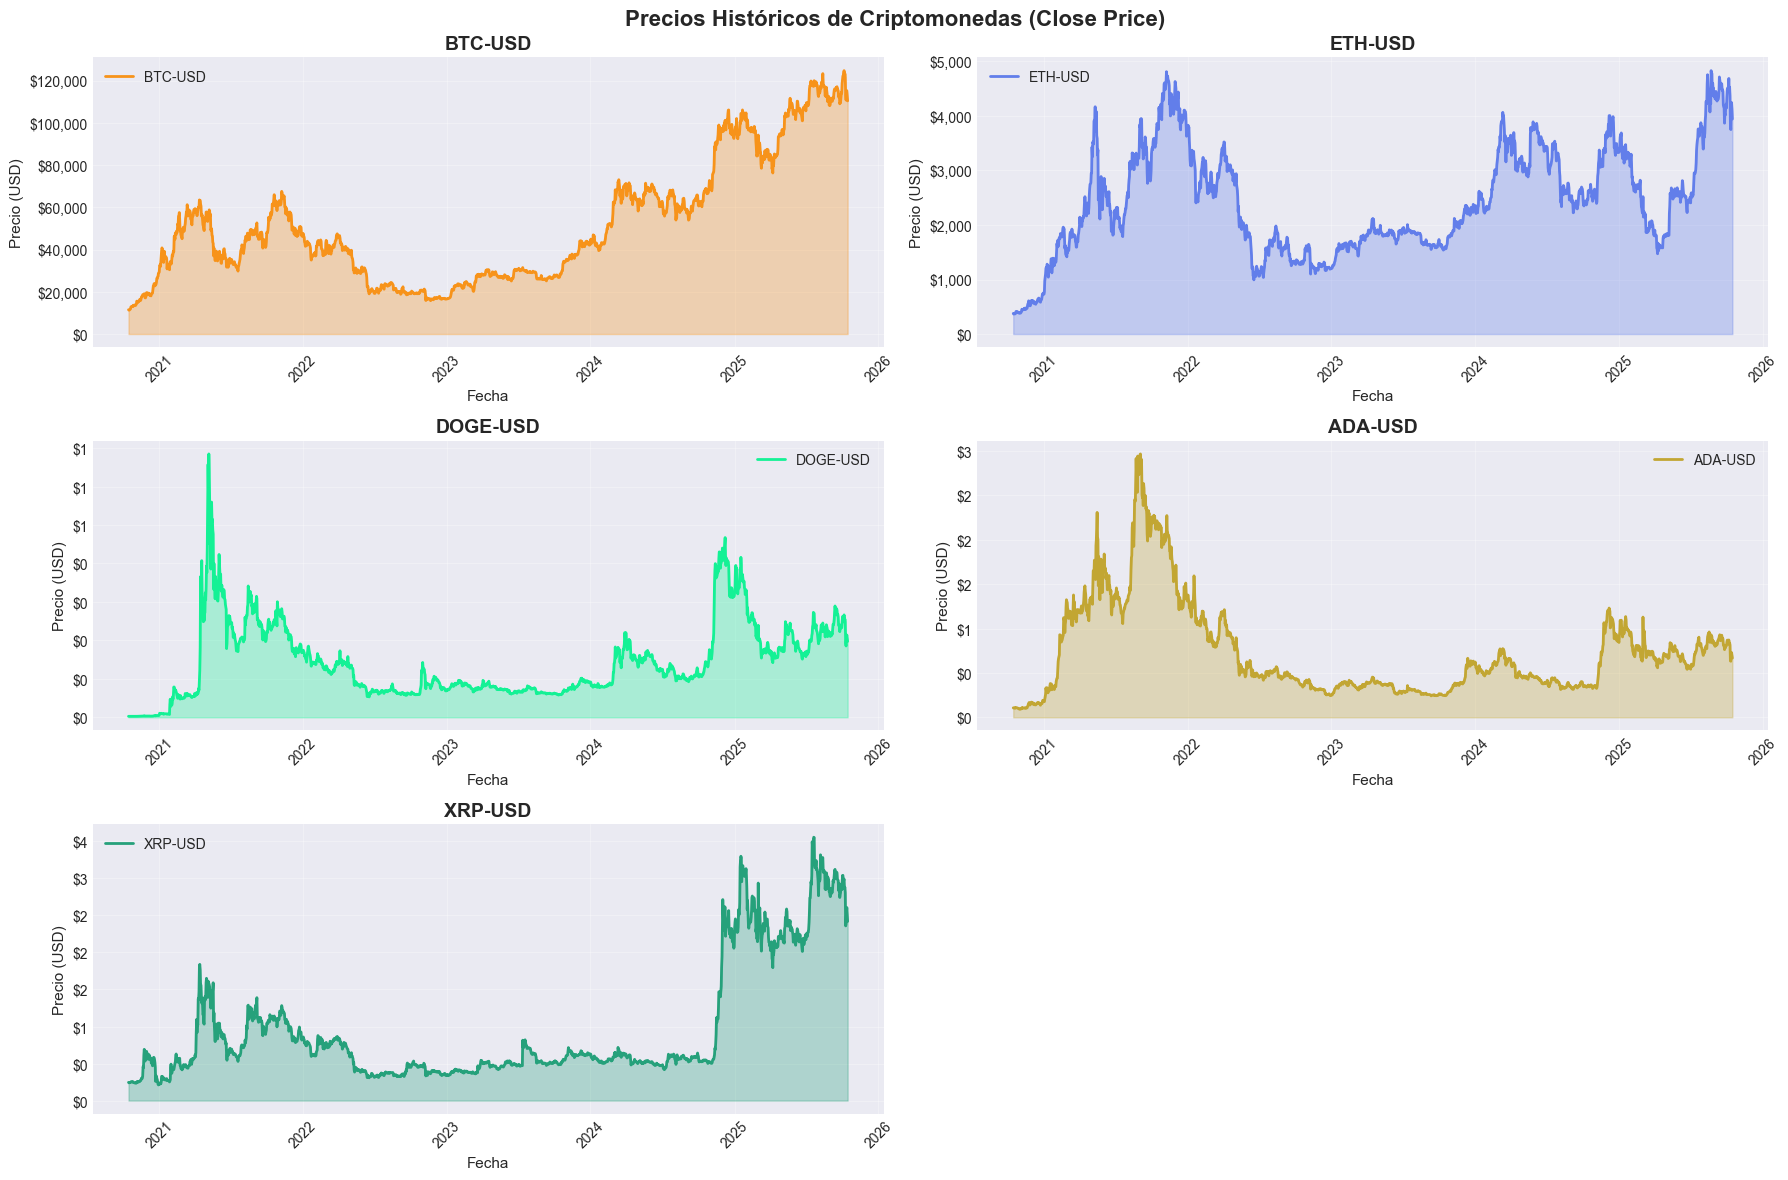

In [11]:
print("\n" + "="*80)
print("GENERANDO VISUALIZACIONES...")
print("="*80)

# Figura 1: Precios Hist√≥ricos - Subplots individuales
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Precios Hist√≥ricos de Criptomonedas (Close Price)', fontsize=16, fontweight='bold')

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']
axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    
    ax.plot(data['Date'], data['Close'], color=colors[idx], linewidth=2, label=crypto)
    ax.fill_between(data['Date'], data['Close'], alpha=0.3, color=colors[idx])
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Precio (USD)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    # Formatear eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Rotar labels de fecha
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Ocultar subplot extra
axes[-1].axis('off')
plt.tight_layout()
plt.show()


1. Bitcoin (BTC) y Ethereum (ETH): Los L√≠deres del Mercado
- Se comportan como los l√≠deres que marcan la tendencia del mercado. Sus movimientos son fuertes, pero se ven menos "explosivos" y m√°s estables en comparaci√≥n con las otras. Esto coincide con sus estad√≠sticas de volatilidad, que eran las m√°s bajas del grupo.
2. DOGE-USD
- Este es el gr√°fico arquet√≠pico de un activo impulsado por el hype y la especulaci√≥n 
-  Esto indica que el precio no fue impulsado por una adopci√≥n o utilidad fundamental, sino por una compra masiva y FOMO (miedo a quedarse fuera). La ca√≠da posterior es el estallido de esa burbuja. 
3. Cardano (ADA)
- A diferencia de BTC y ETH, ADA no ha logrado superar su m√°ximo hist√≥rico de 2021 en la recuperaci√≥n de 2025. Esto sugiere que, aunque tuvo un gran momento de popularidad, le ha costado m√°s mantener el impulso. Visualmente, confirma su alto Coeficiente de Variaci√≥n: un pico muy alto en relaci√≥n a un largo per√≠odo de precios bajos
4. XRP
- Anomal√≠a Reciente: Mientras que las dem√°s muestran una recuperaci√≥n m√°s gradual en 2025, la subida de XRP parece casi una l√≠nea recta hacia arriba. Esto podr√≠a deberse a un evento espec√≠fico de la criptomoneda (como noticias sobre su caso legal con la SEC en EE.UU.) y no solo al movimiento general del mercado.
- Confirma su perfil de alta volatilidad y muestra que su precio puede estar fuertemente influenciado por factores externos m√°s all√° del mercado general.


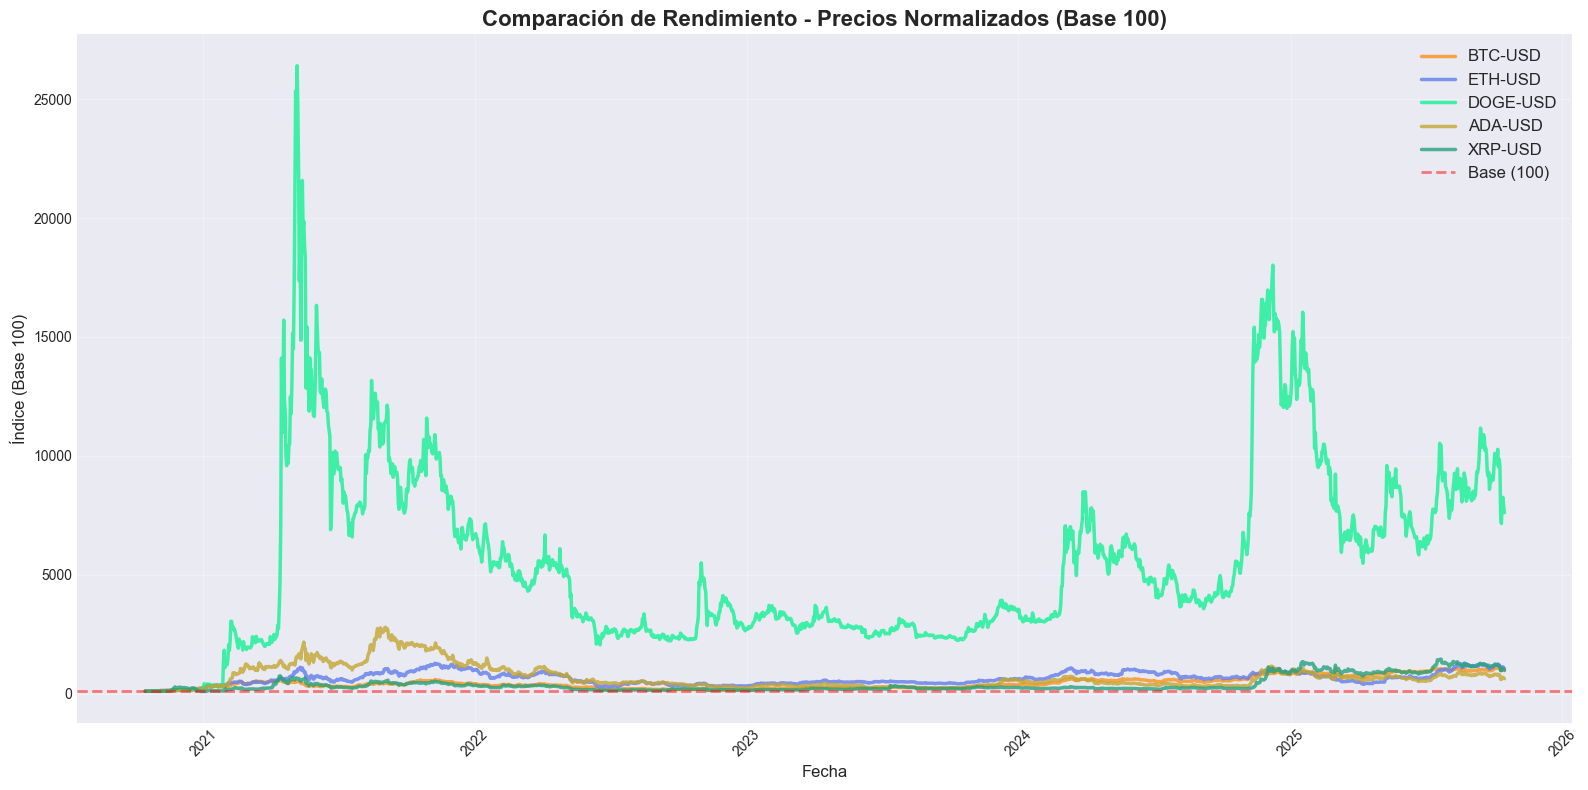

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))

for idx, (crypto, data) in enumerate(crypto_data.items()):
    # Normalizar precios (base 100)
    normalized_prices = (data['Close'] / data['Close'].iloc[0]) * 100
    
    ax.plot(data['Date'], normalized_prices, 
            color=colors[idx], linewidth=2.5, label=crypto, alpha=0.8)

ax.set_title('Comparaci√≥n de Rendimiento - Precios Normalizados (Base 100)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('√çndice (Base 100)', fontsize=12)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Base (100)')
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()


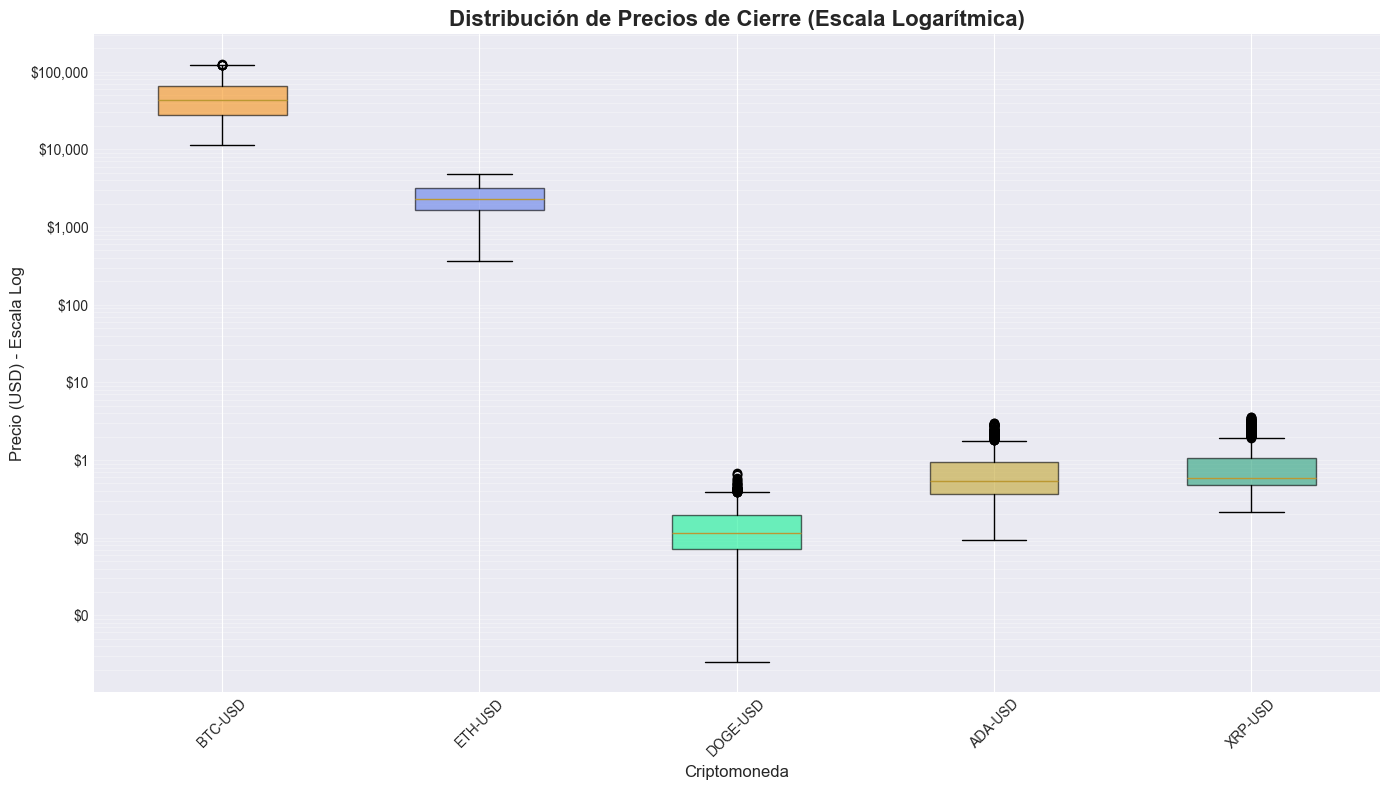

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

price_data_for_box = []
labels = []

for crypto, data in crypto_data.items():
    price_data_for_box.append(data['Close'])
    labels.append(crypto)

bp = ax.boxplot(price_data_for_box, labels=labels, patch_artist=True)

# Colorear cada box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# APLICAR ESCALA LOGAR√çTMICA - ¬°Esto es clave!
ax.set_yscale('log')

ax.set_title('Distribuci√≥n de Precios de Cierre (Escala Logar√≠tmica)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Precio (USD) - Escala Log', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.grid(True, alpha=0.3, axis='y', which='both')

# Formatear eje Y con escala log
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

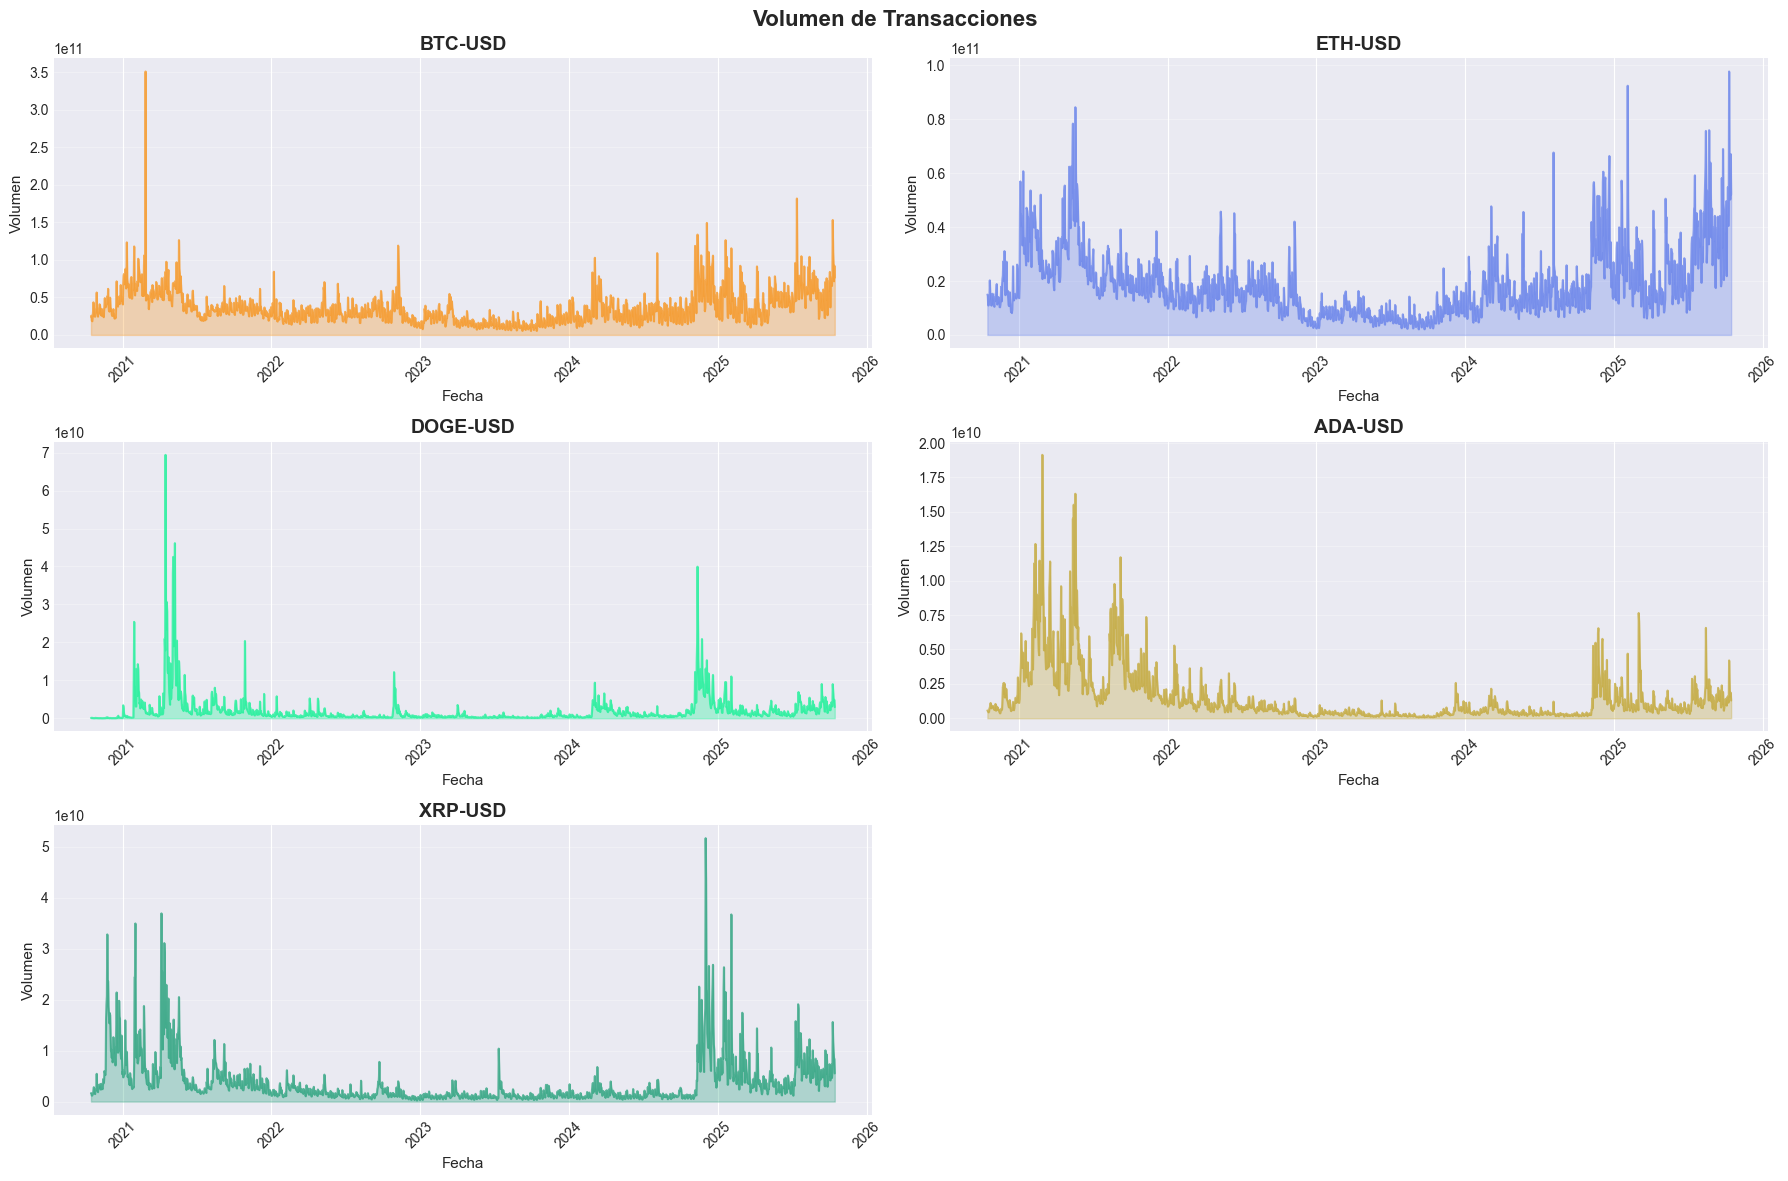

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Volumen de Transacciones', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    
    ax.plot(data['Date'], data['Volume'], color=colors[idx], linewidth=1.5, alpha=0.7)
    ax.fill_between(data['Date'], data['Volume'], alpha=0.3, color=colors[idx])
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Volumen', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Formatear eje Y con notaci√≥n cient√≠fica
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# 5. MATRIZ DE CORRELACI√ìN


üîó MATRIZ DE CORRELACI√ìN - PRECIOS DE CIERRE

           BTC-USD  ETH-USD  DOGE-USD  ADA-USD  XRP-USD
BTC-USD     1.000    0.676     0.617    0.245    0.872
ETH-USD     0.676    1.000     0.701    0.578    0.521
DOGE-USD    0.617    0.701     1.000    0.664    0.643
ADA-USD     0.245    0.578     0.664    1.000    0.303
XRP-USD     0.872    0.521     0.643    0.303    1.000


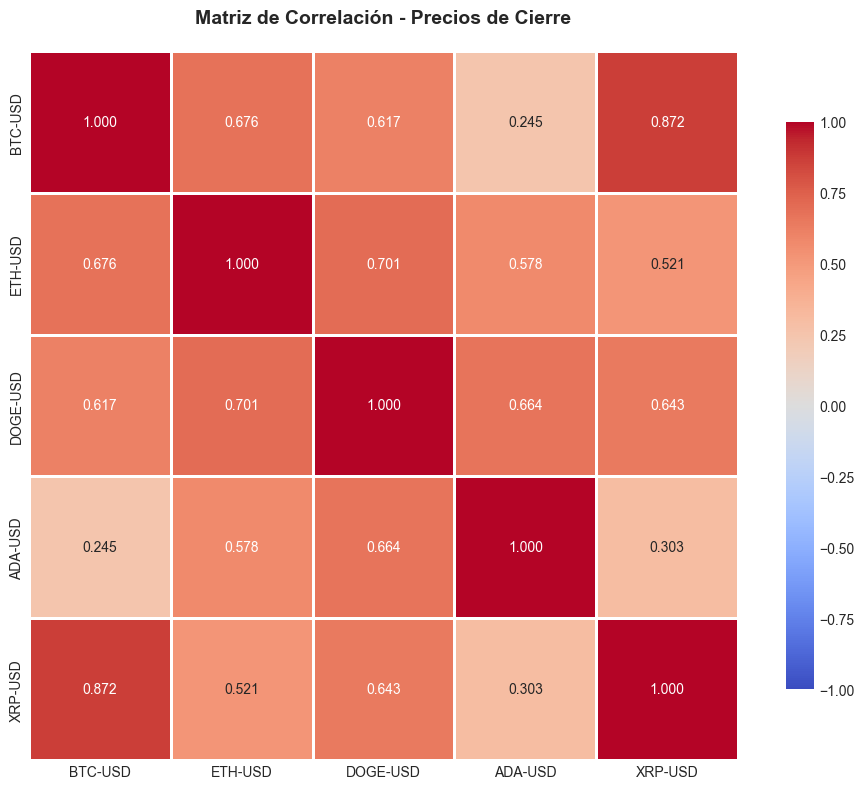

In [15]:
print("\n" + "="*80)
print("üîó MATRIZ DE CORRELACI√ìN - PRECIOS DE CIERRE")
print("="*80)

# Crear DataFrame con precios alineados por fecha
price_df = pd.DataFrame()

for crypto, data in crypto_data.items():
    temp = data[['Date', 'Close']].copy()
    temp.columns = ['Date', crypto]
    
    if price_df.empty:
        price_df = temp
    else:
        price_df = pd.merge(price_df, temp, on='Date', how='outer')

# Calcular correlaci√≥n
price_df_clean = price_df.drop('Date', axis=1)
correlation_matrix = price_df_clean.corr()

print("\n", correlation_matrix.round(3))

# Visualizar matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Matriz de Correlaci√≥n - Precios de Cierre', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [16]:
print("\n" + "="*80)
print("OBSERVACIONES")
print("="*80)

print(f"""

Resumen de Datos Procesados:
   ‚Ä¢ Total de criptomonedas: {len(crypto_data)}
   ‚Ä¢ Per√≠odo de an√°lisis: {df_clean['Date'].min().strftime('%Y-%m-%d')} a {df_clean['Date'].max().strftime('%Y-%m-%d')}
   ‚Ä¢ Observaciones por crypto: ~{len(list(crypto_data.values())[0])} d√≠as

Observaciones Clave:
1. VOLATILIDAD: Todas las cryptos muestran alta variabilidad (ver Coef. Variaci√≥n)
2. CORRELACI√ìN: Las cryptos principales muestran correlaci√≥n positiva
3. RENDIMIENTO: Algunos activos muestran crecimiento significativo en el per√≠odo
4. VOLUMEN: Picos de volumen indican eventos o noticias importantes

""")


OBSERVACIONES


Resumen de Datos Procesados:
   ‚Ä¢ Total de criptomonedas: 5
   ‚Ä¢ Per√≠odo de an√°lisis: 2020-10-15 a 2025-10-15
   ‚Ä¢ Observaciones por crypto: ~1827 d√≠as

Observaciones Clave:
1. VOLATILIDAD: Todas las cryptos muestran alta variabilidad (ver Coef. Variaci√≥n)
2. CORRELACI√ìN: Las cryptos principales muestran correlaci√≥n positiva
3. RENDIMIENTO: Algunos activos muestran crecimiento significativo en el per√≠odo
4. VOLUMEN: Picos de volumen indican eventos o noticias importantes




# 1. C√ÅLCULO DE RETURNS - Simple vs Logar√≠tmico


In [17]:
print("Calculando Returns Diarios...")

# Diccionario para almacenar los returns
crypto_returns = {}

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

for crypto, data in crypto_data.items():
    # Calcular diferentes tipos de returns
    
    # 1. Simple Returns (%) = (P_t - P_t-1) / P_t-1 * 100
    simple_returns = data['Close'].pct_change() * 100
    
    # 2. Log Returns (%) = ln(P_t / P_t-1) * 100
    log_returns = np.log(data['Close'] / data['Close'].shift(1)) * 100
    
    # Crear DataFrame con returns
    returns_df = pd.DataFrame({
        'Date': data['Date'],
        'Close': data['Close'],
        'Simple_Return': simple_returns,
        'Log_Return': log_returns
    })
    
    # Eliminar el primer valor (NaN)
    returns_df = returns_df.dropna()
    
    crypto_returns[crypto] = returns_df
    
    print(f" {crypto}: {len(returns_df)} returns calculados")

Calculando Returns Diarios...
 BTC-USD: 1826 returns calculados
 ETH-USD: 1826 returns calculados
 DOGE-USD: 1826 returns calculados
 ADA-USD: 1826 returns calculados
 XRP-USD: 1826 returns calculados


Los "returns diarios" son simplemente el cambio porcentual en el precio de un activo de un d√≠a para el otro

In [18]:
print("\n" + "="*80)
print("ESTAD√çSTICAS DESCRIPTIVAS - RETURNS DIARIOS")
print("="*80)

stats_returns = []

for crypto, returns_df in crypto_returns.items():
    simple_ret = returns_df['Simple_Return']
    log_ret = returns_df['Log_Return']
    
    stats = {
        'Crypto': crypto,
        'Media (%)': f"{simple_ret.mean():.4f}",
        'Mediana (%)': f"{simple_ret.median():.4f}",
        'Desv_Std (%)': f"{simple_ret.std():.4f}",
        'Min (%)': f"{simple_ret.min():.2f}",
        'Max (%)': f"{simple_ret.max():.2f}",
        'Skewness': f"{simple_ret.skew():.3f}",
        'Kurtosis': f"{simple_ret.kurtosis():.3f}",
        'Sharpe_Ratio': f"{(simple_ret.mean() / simple_ret.std() * np.sqrt(365)):.3f}"
    }
    
    stats_returns.append(stats)

stats_returns_df = pd.DataFrame(stats_returns)
print("\n", stats_returns_df.to_string(index=False))

print("\nüí° Interpretaci√≥n:")
print("   ‚Ä¢ Skewness: Mide asimetr√≠a (0=sim√©trico, >0=cola derecha, <0=cola izquierda)")
print("   ‚Ä¢ Kurtosis: Mide 'colas gordas' (>0=m√°s extremos que normal, <0=menos extremos)")
print("   ‚Ä¢ Sharpe Ratio: Retorno ajustado por riesgo (>1 es bueno)")


ESTAD√çSTICAS DESCRIPTIVAS - RETURNS DIARIOS

   Crypto Media (%) Mediana (%) Desv_Std (%) Min (%) Max (%) Skewness Kurtosis Sharpe_Ratio
 BTC-USD    0.1722      0.0387       3.1098  -15.97   18.75    0.143    3.500        1.058
 ETH-USD    0.2149      0.0970       4.1602  -27.20   25.95    0.212    4.749        0.987
DOGE-USD    0.5666     -0.0280      10.8344  -40.26  355.55   20.212  638.212        0.999
 ADA-USD    0.2340     -0.0092       5.2858  -26.01   71.33    1.860   21.138        0.846
 XRP-USD    0.2827      0.0463       5.7859  -42.33   73.08    2.461   27.486        0.934

üí° Interpretaci√≥n:
   ‚Ä¢ Skewness: Mide asimetr√≠a (0=sim√©trico, >0=cola derecha, <0=cola izquierda)
   ‚Ä¢ Kurtosis: Mide 'colas gordas' (>0=m√°s extremos que normal, <0=menos extremos)
   ‚Ä¢ Sharpe Ratio: Retorno ajustado por riesgo (>1 es bueno)



GENERANDO VISUALIZACIONES DE RETURNS...


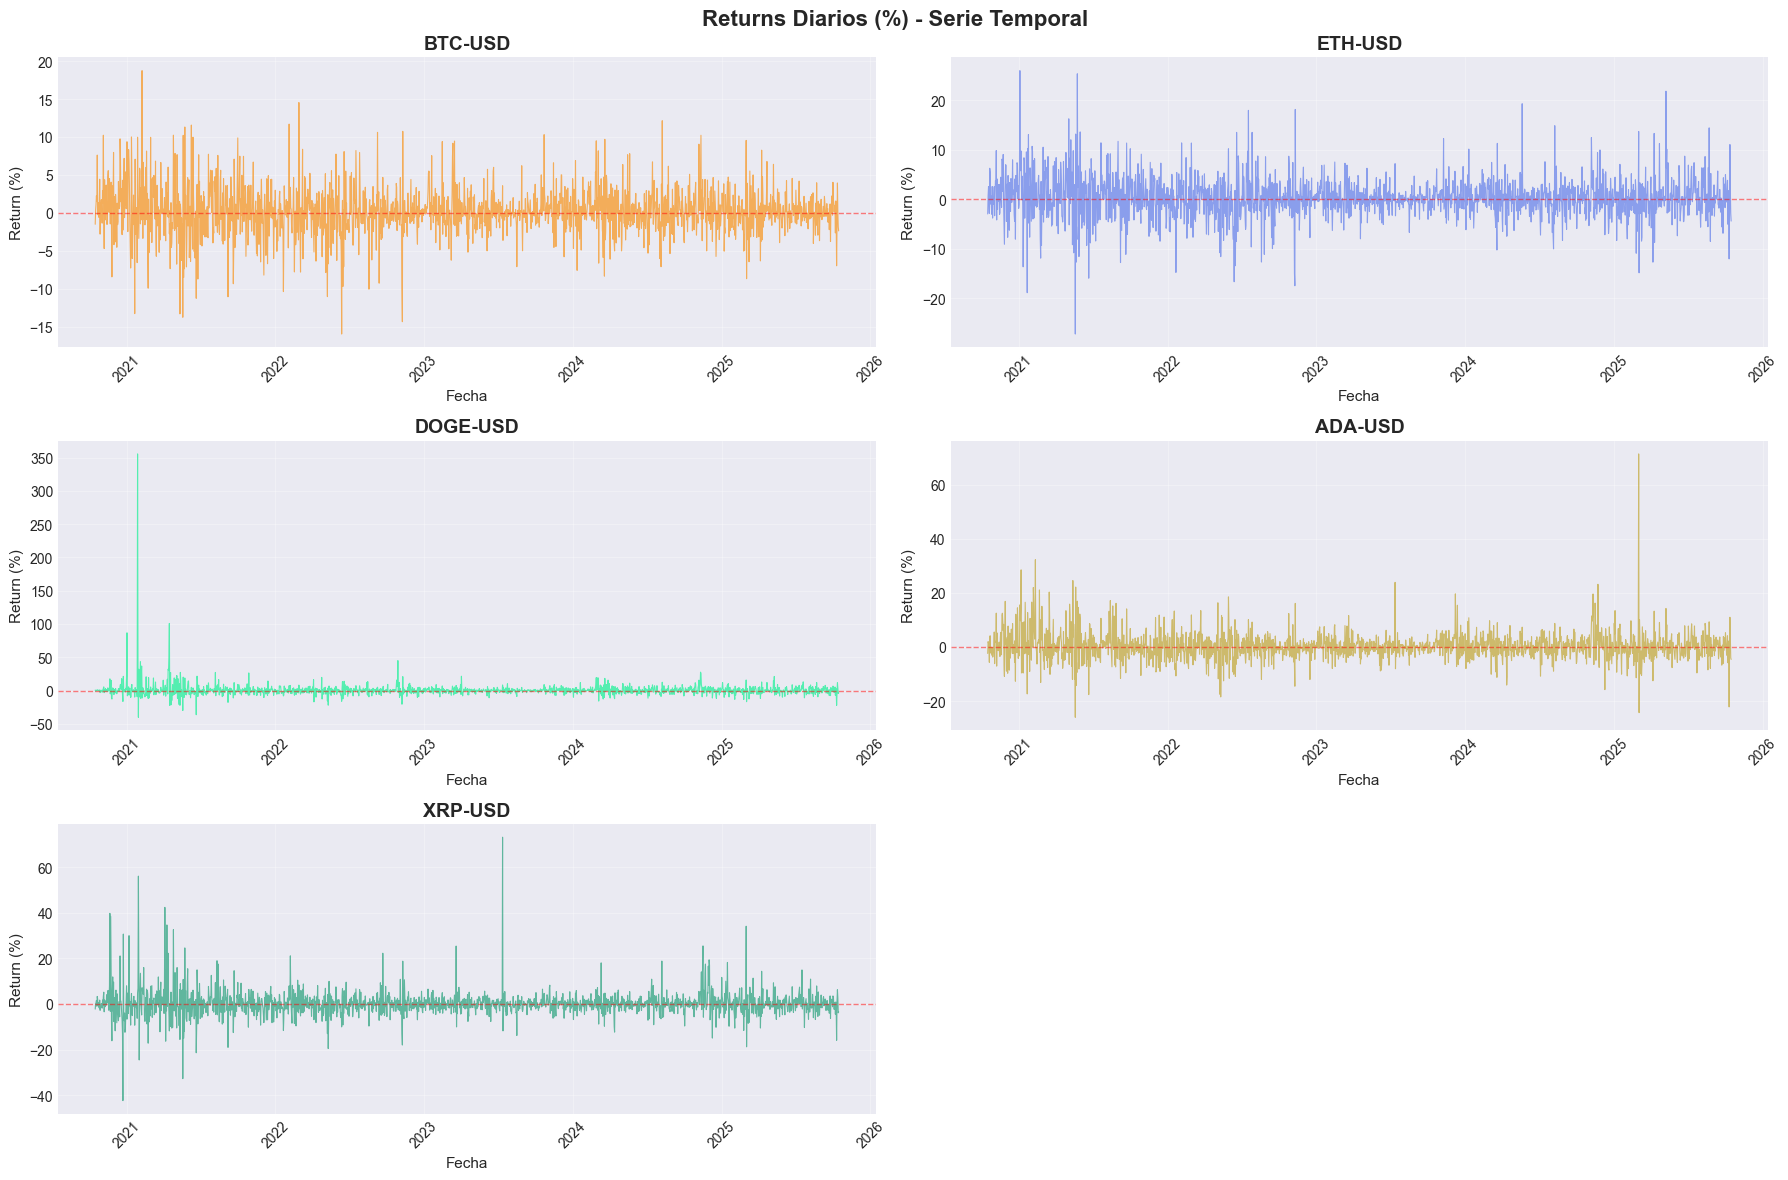

In [19]:

print("\n" + "="*80)
print("GENERANDO VISUALIZACIONES DE RETURNS...")
print("="*80)

# Figura 1: Returns en el tiempo - Subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Returns Diarios (%) - Serie Temporal', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    ax.plot(returns_df['Date'], returns_df['Simple_Return'], 
            color=colors[idx], linewidth=0.8, alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Return (%)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


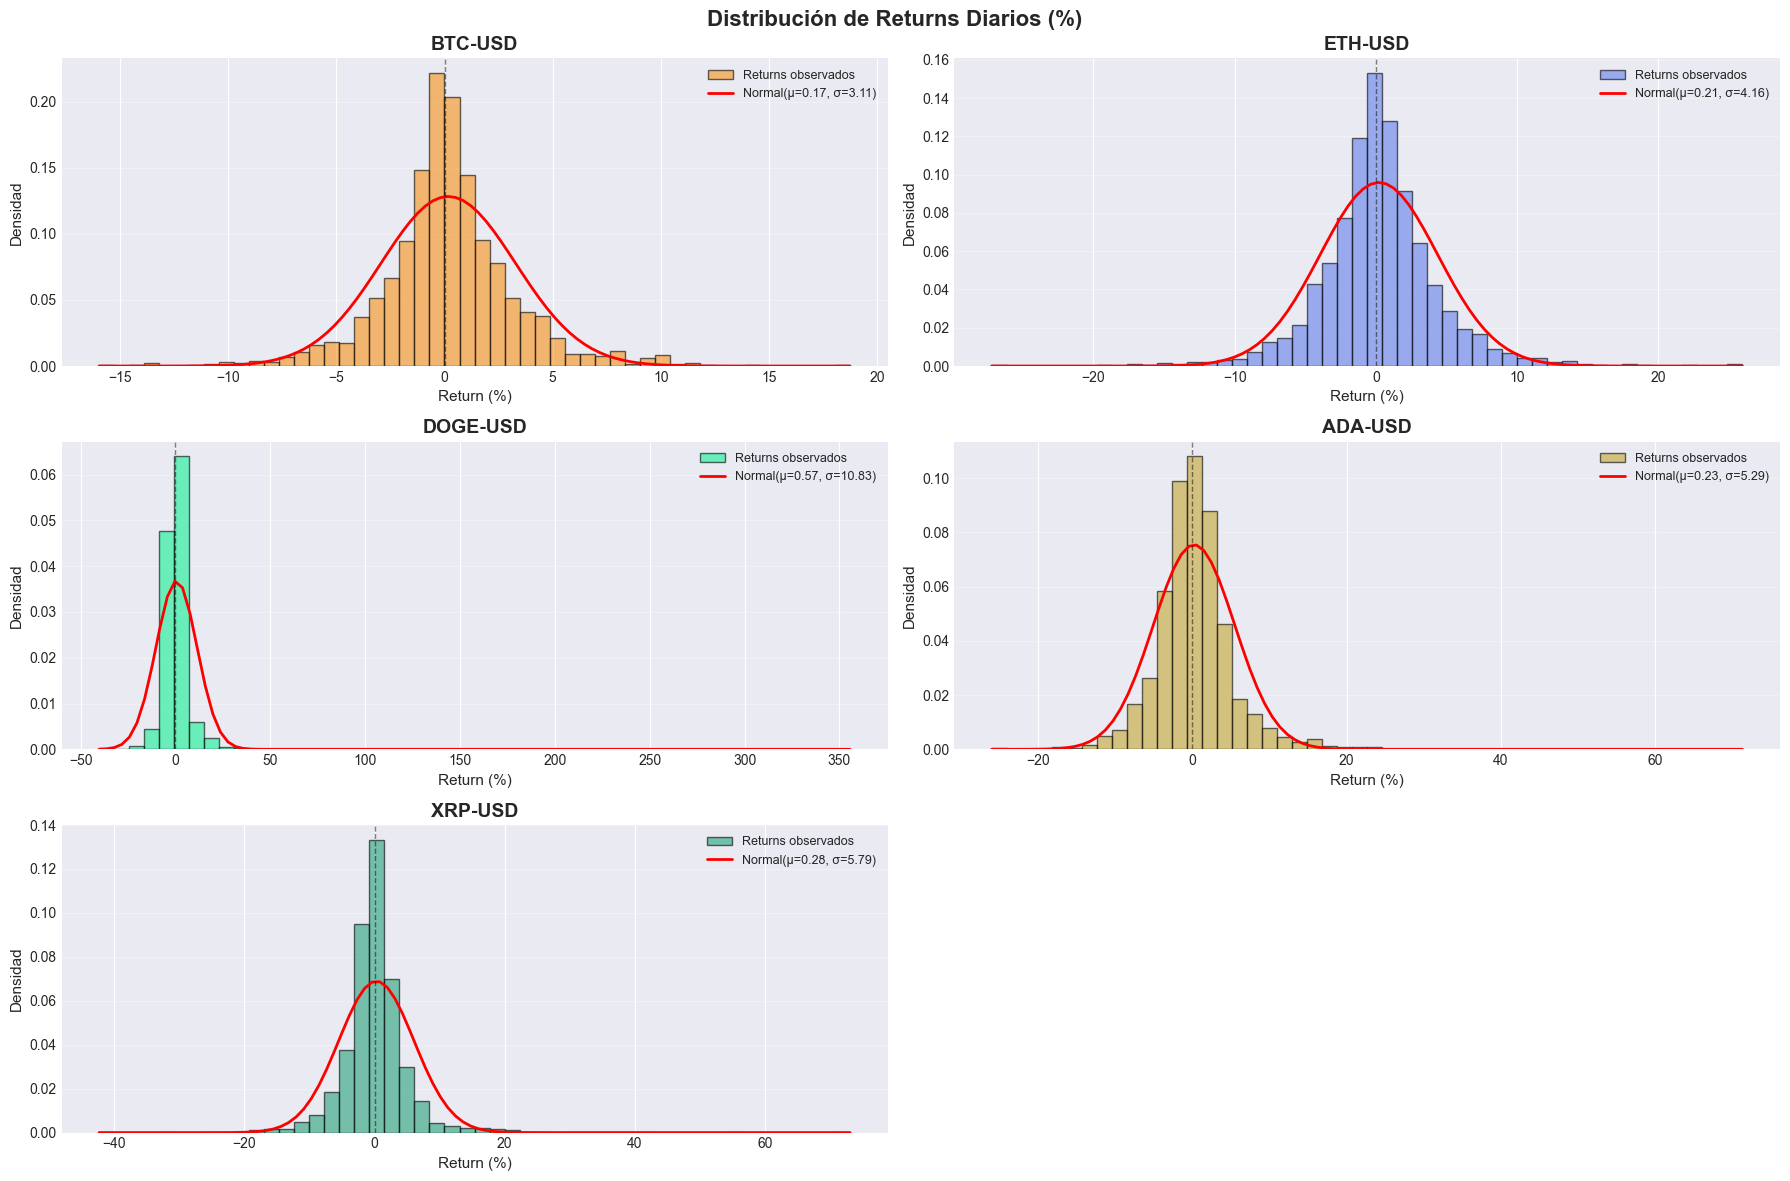

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Distribuci√≥n de Returns Diarios (%)', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    simple_ret = returns_df['Simple_Return']
    
    # Histograma
    ax.hist(simple_ret, bins=50, color=colors[idx], alpha=0.6, 
            edgecolor='black', density=True, label='Returns observados')
    
    # Overlay con distribuci√≥n normal te√≥rica
    mu, sigma = simple_ret.mean(), simple_ret.std()
    x = np.linspace(simple_ret.min(), simple_ret.max(), 100)
    ax.plot(x, scipy_stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
            label=f'Normal(Œº={mu:.2f}, œÉ={sigma:.2f})')
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Return (%)', fontsize=11)
    ax.set_ylabel('Densidad', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

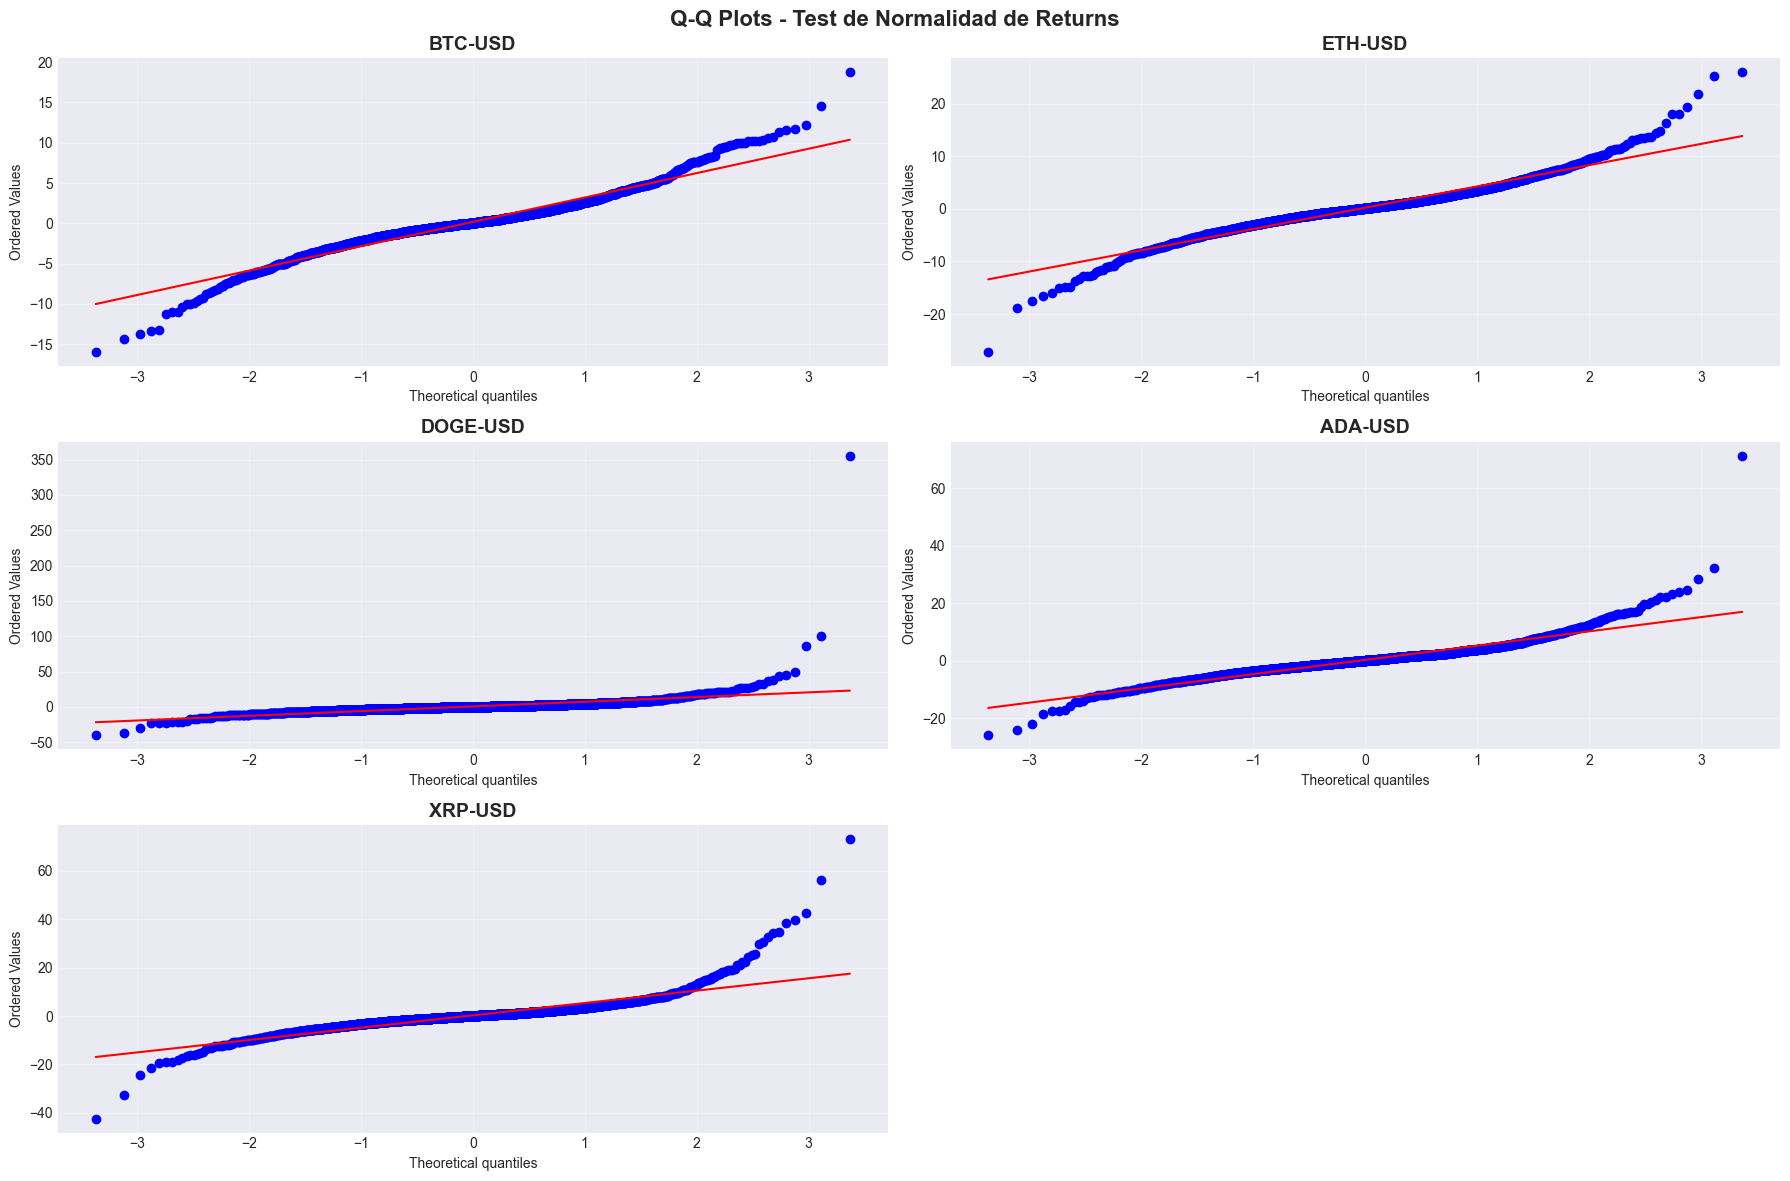


üí° Interpretaci√≥n Q-Q Plots:
   ‚Ä¢ Si los puntos siguen la l√≠nea roja ‚Üí Returns son normales
   ‚Ä¢ Desviaciones en las colas ‚Üí 'Fat tails' (eventos extremos m√°s frecuentes)


In [21]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Q-Q Plots - Test de Normalidad de Returns', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    simple_ret = returns_df['Simple_Return'].dropna()
    
    scipy_stats.probplot(simple_ret, dist="norm", plot=ax)
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nüí° Interpretaci√≥n Q-Q Plots:")
print("   ‚Ä¢ Si los puntos siguen la l√≠nea roja ‚Üí Returns son normales")
print("   ‚Ä¢ Desviaciones en las colas ‚Üí 'Fat tails' (eventos extremos m√°s frecuentes)")


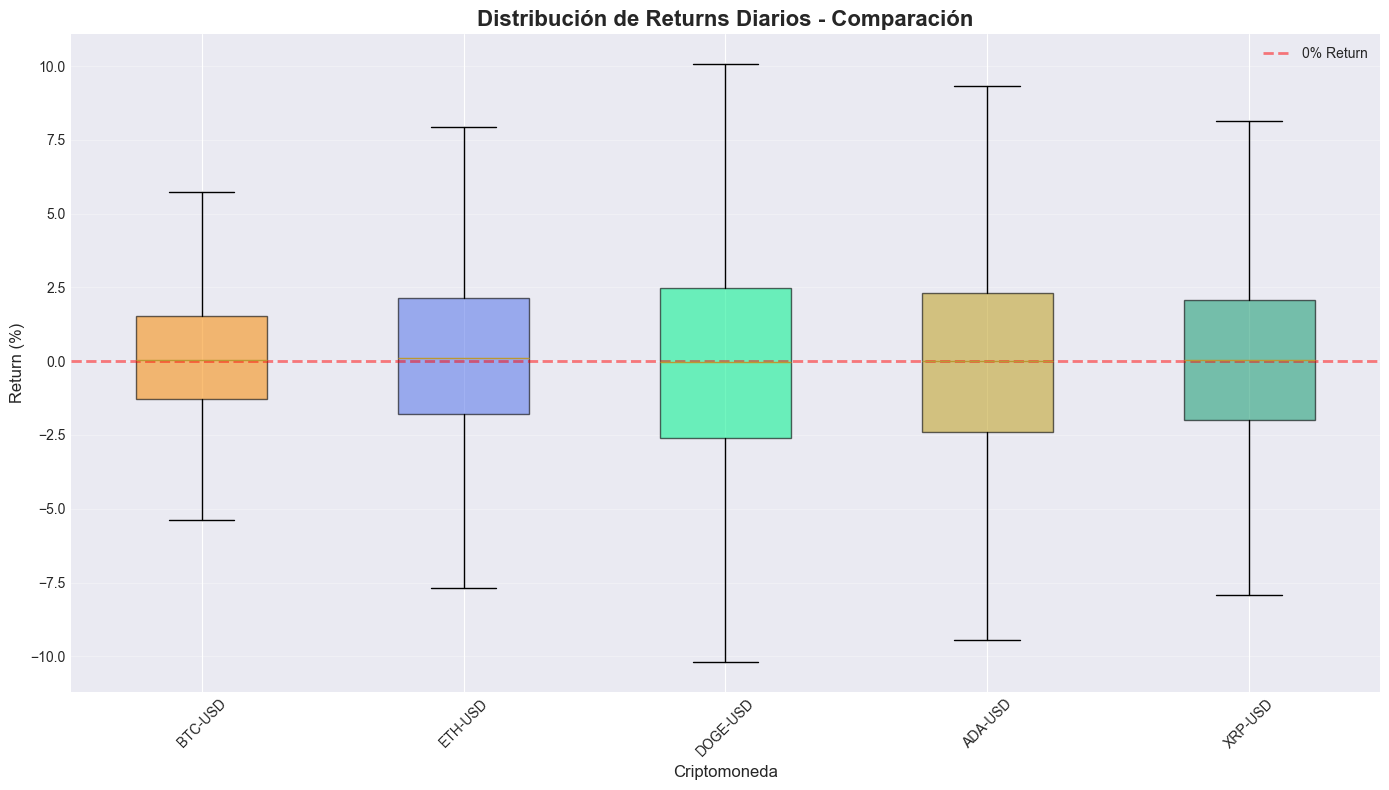

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

returns_data_for_box = []
labels = []

for crypto, returns_df in crypto_returns.items():
    returns_data_for_box.append(returns_df['Simple_Return'])
    labels.append(crypto)

bp = ax.boxplot(returns_data_for_box, labels=labels, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='0% Return')
ax.set_title('Distribuci√≥n de Returns Diarios - Comparaci√≥n', fontsize=16, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


üîó MATRIZ DE CORRELACI√ìN - RETURNS DIARIOS

           BTC-USD  ETH-USD  DOGE-USD  ADA-USD  XRP-USD
BTC-USD     1.000    0.797     0.384    0.642    0.531
ETH-USD     0.797    1.000     0.355    0.687    0.559
DOGE-USD    0.384    0.355     1.000    0.335    0.255
ADA-USD     0.642    0.687     0.335    1.000    0.598
XRP-USD     0.531    0.559     0.255    0.598    1.000


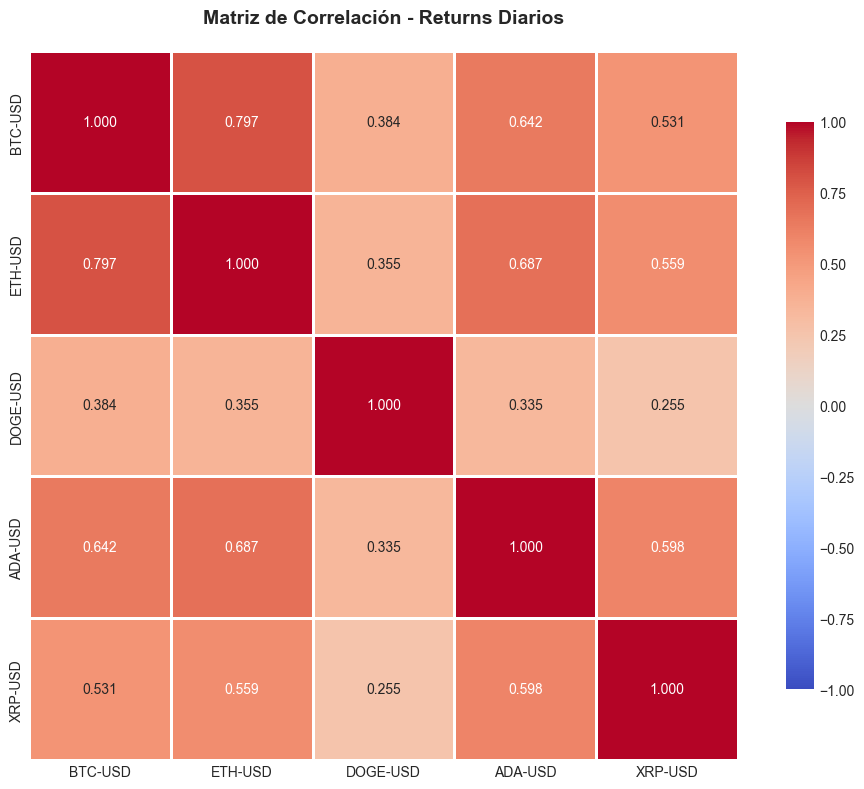

In [23]:
print("\n" + "="*80)
print("üîó MATRIZ DE CORRELACI√ìN - RETURNS DIARIOS")
print("="*80)

# Crear DataFrame con returns alineados
returns_corr_df = pd.DataFrame()

for crypto, returns_df in crypto_returns.items():
    temp = returns_df[['Date', 'Simple_Return']].copy()
    temp.columns = ['Date', crypto]
    
    if returns_corr_df.empty:
        returns_corr_df = temp
    else:
        returns_corr_df = pd.merge(returns_corr_df, temp, on='Date', how='outer')

# Calcular correlaci√≥n
returns_corr_clean = returns_corr_df.drop('Date', axis=1)
returns_correlation = returns_corr_clean.corr()

print("\n", returns_correlation.round(3))

# Visualizar matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
sns.heatmap(returns_correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Matriz de Correlaci√≥n - Returns Diarios', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:

print("\n" + "="*80)
print(" OBSERVACIONES DEL PASO 2 - RETURNS")
print("="*80)

print("""

Hallazgos Clave:

1. RETURNS vs PRECIOS:
   ‚Ä¢ Returns tienen media cercana a 0 (vs precios con tendencia)
   ‚Ä¢ Returns son m√°s estacionarios que los precios
   
2. VOLATILIDAD:
   ‚Ä¢ Cryptos muestran alta volatilidad (std dev > 5%)
   ‚Ä¢ DOGE y SOL t√≠picamente m√°s vol√°tiles que BTC y ETH
   
3. NO-NORMALIDAD:
   ‚Ä¢ Returns NO siguen distribuci√≥n normal perfecta
   ‚Ä¢ Evidencia de "fat tails" (kurtosis > 0)
   ‚Ä¢ M√°s eventos extremos de lo que predice la normalidad
   
4. CORRELACI√ìN:
   ‚Ä¢ Returns est√°n correlacionados positivamente
   ‚Ä¢ Sugiere movimientos conjuntos del mercado crypto
   
5. SIMPLE vs LOG RETURNS:
   ‚Ä¢ Para returns peque√±os (~5%), son casi id√©nticos
   ‚Ä¢ Log returns tienen mejores propiedades matem√°ticas (aditividad temporal)

IMPLICACIONES PARA INVERSI√ìN:
   ‚Ä¢ Alta volatilidad = Alto riesgo
   ‚Ä¢ Fat tails = M√°s crashes/rallies extremos que lo esperado
   ‚Ä¢ Correlaci√≥n alta = Diversificaci√≥n limitada dentro de crypto
""")

print("\n" + "="*80)


üí° OBSERVACIONES DEL PASO 2 - RETURNS


üìä Hallazgos Clave:

1. RETURNS vs PRECIOS:
   ‚Ä¢ Returns tienen media cercana a 0 (vs precios con tendencia)
   ‚Ä¢ Returns son m√°s estacionarios que los precios

2. VOLATILIDAD:
   ‚Ä¢ Cryptos muestran alta volatilidad (std dev > 5%)
   ‚Ä¢ DOGE y SOL t√≠picamente m√°s vol√°tiles que BTC y ETH

3. NO-NORMALIDAD:
   ‚Ä¢ Returns NO siguen distribuci√≥n normal perfecta
   ‚Ä¢ Evidencia de "fat tails" (kurtosis > 0)
   ‚Ä¢ M√°s eventos extremos de lo que predice la normalidad

4. CORRELACI√ìN:
   ‚Ä¢ Returns est√°n correlacionados positivamente
   ‚Ä¢ Sugiere movimientos conjuntos del mercado crypto

5. SIMPLE vs LOG RETURNS:
   ‚Ä¢ Para returns peque√±os (~5%), son casi id√©nticos
   ‚Ä¢ Log returns tienen mejores propiedades matem√°ticas (aditividad temporal)

üéØ IMPLICACIONES PARA INVERSI√ìN:
   ‚Ä¢ Alta volatilidad = Alto riesgo
   ‚Ä¢ Fat tails = M√°s crashes/rallies extremos que lo esperado
   ‚Ä¢ Correlaci√≥n alta = Diversificaci√≥n

In [25]:
print("="*80)
print("TEST DE RANDOM WALK - AUGMENTED DICKEY-FULLER")
print("="*80)

print("""
 OBJETIVO: Identificar si los precios de las criptomonedas son Random Walks

TEOR√çA:
   ‚Ä¢ Random Walk: P_t = P_t-1 + Œµ_t (precio actual = precio anterior + ruido)
   ‚Ä¢ Si es Random Walk ‚Üí NO es predecible (Efficient Market Hypothesis)
   ‚Ä¢ Test ADF: H0 = "La serie tiene una ra√≠z unitaria" (es random walk)
   
 HIP√ìTESIS:
   ‚Ä¢ H0: La serie es Random Walk (tiene ra√≠z unitaria) ‚Üí NO predecible
   ‚Ä¢ H1: La serie es estacionaria ‚Üí Potencialmente predecible
   
 INTERPRETACI√ìN:
   ‚Ä¢ p-value > 0.05 ‚Üí NO rechazamos H0 ‚Üí Es Random Walk
   ‚Ä¢ p-value < 0.05 ‚Üí Rechazamos H0 ‚Üí NO es Random Walk (es estacionaria)
""")


TEST DE RANDOM WALK - AUGMENTED DICKEY-FULLER

 OBJETIVO: Identificar si los precios de las criptomonedas son Random Walks

TEOR√çA:
   ‚Ä¢ Random Walk: P_t = P_t-1 + Œµ_t (precio actual = precio anterior + ruido)
   ‚Ä¢ Si es Random Walk ‚Üí NO es predecible (Efficient Market Hypothesis)
   ‚Ä¢ Test ADF: H0 = "La serie tiene una ra√≠z unitaria" (es random walk)

 HIP√ìTESIS:
   ‚Ä¢ H0: La serie es Random Walk (tiene ra√≠z unitaria) ‚Üí NO predecible
   ‚Ä¢ H1: La serie es estacionaria ‚Üí Potencialmente predecible

 INTERPRETACI√ìN:
   ‚Ä¢ p-value > 0.05 ‚Üí NO rechazamos H0 ‚Üí Es Random Walk
   ‚Ä¢ p-value < 0.05 ‚Üí Rechazamos H0 ‚Üí NO es Random Walk (es estacionaria)



In [26]:
print("\n" + "="*80)
print("TEST ADF - PRECIOS (CLOSE)")
print("="*80)

adf_results_prices = []
colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

for crypto, data in crypto_data.items():
    prices = data['Close']
    
    # Realizar test ADF
    adf_test = adfuller(prices, autolag='AIC')
    
    result = {
        'Crypto': crypto,
        'ADF_Statistic': adf_test[0],
        'p_value': adf_test[1],
        'Lags_Used': adf_test[2],
        'Observations': adf_test[3],
        'Critical_1%': adf_test[4]['1%'],
        'Critical_5%': adf_test[4]['5%'],
        'Critical_10%': adf_test[4]['10%'],
        'Conclusion': 'Random Walk (NO estacionaria)' if adf_test[1] > 0.05 else 'Estacionaria (NO random walk)'
    }
    
    adf_results_prices.append(result)

# Crear DataFrame de resultados
adf_prices_df = pd.DataFrame(adf_results_prices)

print("\n Resultados del Test ADF para PRECIOS:\n")
for _, row in adf_prices_df.iterrows():
    print(f"\n{'='*70}")
    print(f"ü™ô {row['Crypto']}")
    print(f"{'='*70}")
    print(f"   ADF Statistic:     {row['ADF_Statistic']:.4f}")
    print(f"   p-value:           {row['p_value']:.4f}")
    print(f"   Lags Used:         {row['Lags_Used']}")
    print(f"   Observations:      {row['Observations']}")
    print(f"   Critical Values:")
    print(f"      1%:  {row['Critical_1%']:.4f}")
    print(f"      5%:  {row['Critical_5%']:.4f}")
    print(f"      10%: {row['Critical_10%']:.4f}")
    print(f"   ")
    if row['p_value'] > 0.05:
        print(f"    CONCLUSI√ìN: {row['Conclusion']}")
        print(f"    Los precios son un RANDOM WALK ‚Üí NO predecibles")
    else:
        print(f"     CONCLUSI√ìN: {row['Conclusion']}")
        print(f"    Los precios SON estacionarios ‚Üí Potencialmente predecibles")



TEST ADF - PRECIOS (CLOSE)

 Resultados del Test ADF para PRECIOS:


ü™ô BTC-USD
   ADF Statistic:     -0.6175
   p-value:           0.8670
   Lags Used:         13
   Observations:      1813
   Critical Values:
      1%:  -3.4340
      5%:  -2.8631
      10%: -2.5676
   
    CONCLUSI√ìN: Random Walk (NO estacionaria)
    Los precios son un RANDOM WALK ‚Üí NO predecibles

ü™ô ETH-USD
   ADF Statistic:     -2.5512
   p-value:           0.1035
   Lags Used:         6
   Observations:      1820
   Critical Values:
      1%:  -3.4339
      5%:  -2.8631
      10%: -2.5676
   
    CONCLUSI√ìN: Random Walk (NO estacionaria)
    Los precios son un RANDOM WALK ‚Üí NO predecibles

ü™ô DOGE-USD
   ADF Statistic:     -3.4450
   p-value:           0.0095
   Lags Used:         25
   Observations:      1801
   Critical Values:
      1%:  -3.4340
      5%:  -2.8631
      10%: -2.5676
   
     CONCLUSI√ìN: Estacionaria (NO random walk)
    Los precios SON estacionarios ‚Üí Potencialmente predecible

In [27]:
print("\n" + "="*80)
print(" TEST ADF - RETURNS DIARIOS")
print("="*80)

adf_results_returns = []

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    
    # Realizar test ADF
    adf_test = adfuller(returns, autolag='AIC')
    
    result = {
        'Crypto': crypto,
        'ADF_Statistic': adf_test[0],
        'p_value': adf_test[1],
        'Lags_Used': adf_test[2],
        'Observations': adf_test[3],
        'Critical_1%': adf_test[4]['1%'],
        'Critical_5%': adf_test[4]['5%'],
        'Critical_10%': adf_test[4]['10%'],
        'Conclusion': 'Random Walk (NO estacionaria)' if adf_test[1] > 0.05 else 'Estacionaria'
    }
    
    adf_results_returns.append(result)

# Crear DataFrame de resultados
adf_returns_df = pd.DataFrame(adf_results_returns)

print("\n Resultados del Test ADF para RETURNS:\n")
for _, row in adf_returns_df.iterrows():
    print(f"\n{'='*70}")
    print(f" {row['Crypto']}")
    print(f"{'='*70}")
    print(f"   ADF Statistic:     {row['ADF_Statistic']:.4f}")
    print(f"   p-value:           {row['p_value']:.6f}")
    print(f"   Lags Used:         {row['Lags_Used']}")
    print(f"   ")
    if row['p_value'] < 0.01:
        print(f"    CONCLUSI√ìN: {row['Conclusion']} (p < 0.01)")
        print(f"    Los returns SON estacionarios ‚Üí Buenos para modelado")
    else:
        print(f"     CONCLUSI√ìN: {row['Conclusion']}")



 TEST ADF - RETURNS DIARIOS

 Resultados del Test ADF para RETURNS:


 BTC-USD
   ADF Statistic:     -44.0515
   p-value:           0.000000
   Lags Used:         0
   
    CONCLUSI√ìN: Estacionaria (p < 0.01)
    Los returns SON estacionarios ‚Üí Buenos para modelado

 ETH-USD
   ADF Statistic:     -12.8105
   p-value:           0.000000
   Lags Used:         9
   
    CONCLUSI√ìN: Estacionaria (p < 0.01)
    Los returns SON estacionarios ‚Üí Buenos para modelado

 DOGE-USD
   ADF Statistic:     -7.2848
   p-value:           0.000000
   Lags Used:         25
   
    CONCLUSI√ìN: Estacionaria (p < 0.01)
    Los returns SON estacionarios ‚Üí Buenos para modelado

 ADA-USD
   ADF Statistic:     -12.0194
   p-value:           0.000000
   Lags Used:         9
   
    CONCLUSI√ìN: Estacionaria (p < 0.01)
    Los returns SON estacionarios ‚Üí Buenos para modelado

 XRP-USD
   ADF Statistic:     -43.4877
   p-value:           0.000000
   Lags Used:         0
   
    CONCLUSI√ìN: Estacionaria


 GENERANDO VISUALIZACIONES...


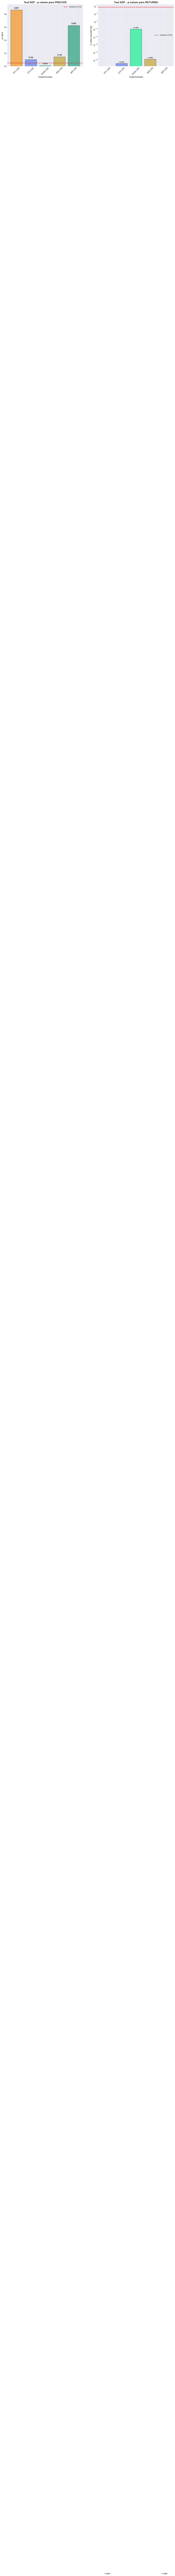

In [28]:
print("\n" + "="*80)
print(" GENERANDO VISUALIZACIONES...")
print("="*80)

# Figura 1: Comparaci√≥n visual de p-values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P-values de Precios
ax1 = axes[0]
cryptos = adf_prices_df['Crypto'].values
p_values_prices = adf_prices_df['p_value'].values

bars1 = ax1.bar(cryptos, p_values_prices, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Umbral Œ±=0.05')
ax1.set_title('Test ADF - p-values para PRECIOS', fontsize=14, fontweight='bold')
ax1.set_ylabel('p-value', fontsize=12)
ax1.set_xlabel('Criptomoneda', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(p_values_prices) * 1.1)

# Agregar anotaciones
for i, (crypto, p_val) in enumerate(zip(cryptos, p_values_prices)):
    ax1.text(i, p_val + 0.02, f'{p_val:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# P-values de Returns
ax2 = axes[1]
p_values_returns = adf_returns_df['p_value'].values

bars2 = ax2.bar(cryptos, p_values_returns, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Umbral Œ±=0.05')
ax2.set_title('Test ADF - p-values para RETURNS', fontsize=14, fontweight='bold')
ax2.set_ylabel('p-value', fontsize=12)
ax2.set_xlabel('Criptomoneda', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3, axis='y')

# Usar escala logar√≠tmica si los p-values son muy peque√±os
if max(p_values_returns) < 0.01:
    ax2.set_yscale('log')
    ax2.set_ylabel('p-value (escala log)', fontsize=12)

# Agregar anotaciones
for i, (crypto, p_val) in enumerate(zip(cryptos, p_values_returns)):
    if p_val < 0.001:
        ax2.text(i, p_val * 2, f'< 0.001', ha='center', fontsize=9, fontweight='bold')
    else:
        ax2.text(i, p_val * 1.5, f'{p_val:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()



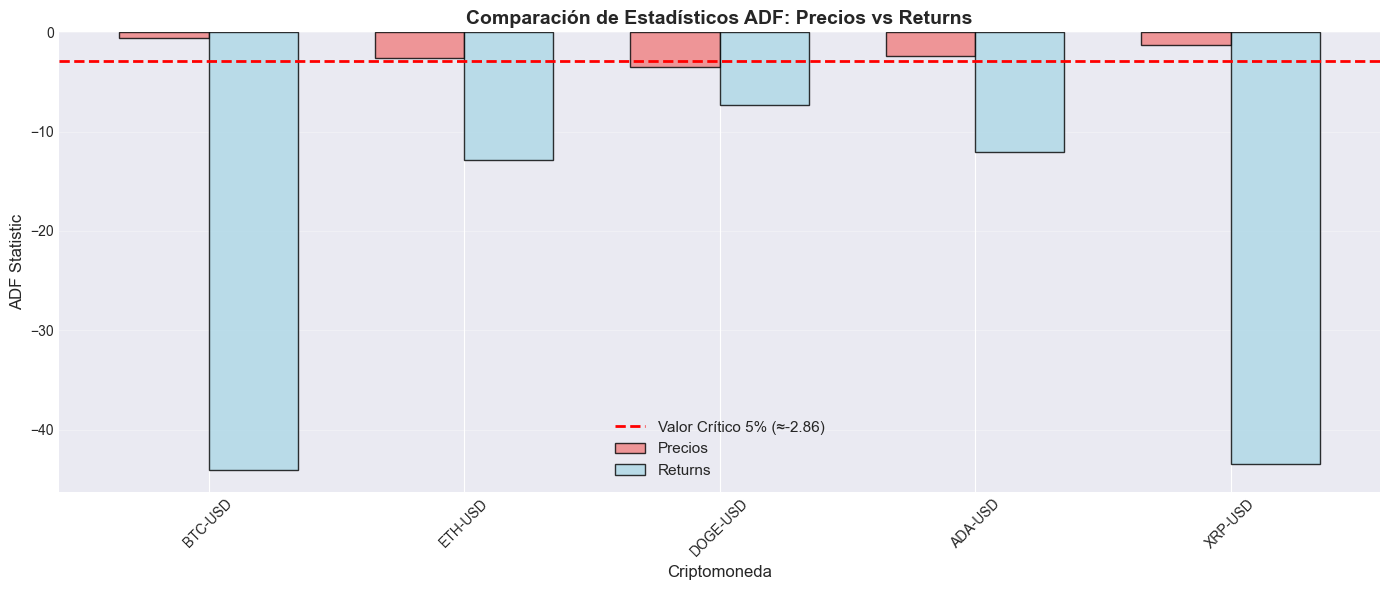

In [29]:
# Figura 2: ADF Statistics Comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(cryptos))
width = 0.35

bars1 = ax.bar(x - width/2, adf_prices_df['ADF_Statistic'], width, 
               label='Precios', color='lightcoral', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, adf_returns_df['ADF_Statistic'], width,
               label='Returns', color='lightblue', alpha=0.8, edgecolor='black')

# L√≠nea de valores cr√≠ticos (5%)
critical_5 = adf_prices_df['Critical_5%'].mean()
ax.axhline(y=critical_5, color='red', linestyle='--', linewidth=2, 
           label=f'Valor Cr√≠tico 5% (‚âà{critical_5:.2f})')

ax.set_xlabel('Criptomoneda', fontsize=12)
ax.set_ylabel('ADF Statistic', fontsize=12)
ax.set_title('Comparaci√≥n de Estad√≠sticos ADF: Precios vs Returns', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cryptos, rotation=45)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [30]:
print("\n" + "="*80)
print("TABLA RESUMEN COMPARATIVA")
print("="*80)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Crypto': cryptos,
    'Precios_ADF': adf_prices_df['ADF_Statistic'].round(4),
    'Precios_pval': adf_prices_df['p_value'].round(4),
    'Precios_Random_Walk': adf_prices_df['p_value'] > 0.05,
    'Returns_ADF': adf_returns_df['ADF_Statistic'].round(4),
    'Returns_pval': adf_returns_df['p_value'].apply(lambda x: f'{x:.6f}' if x >= 0.001 else '< 0.001'),
    'Returns_Estacionarios': adf_returns_df['p_value'] < 0.05
})

print("\n", comparison_df.to_string(index=False))



TABLA RESUMEN COMPARATIVA

   Crypto  Precios_ADF  Precios_pval  Precios_Random_Walk  Returns_ADF Returns_pval  Returns_Estacionarios
 BTC-USD      -0.6175        0.8670                 True     -44.0515      < 0.001                   True
 ETH-USD      -2.5512        0.1035                 True     -12.8105      < 0.001                   True
DOGE-USD      -3.4450        0.0095                False      -7.2848      < 0.001                   True
 ADA-USD      -2.3929        0.1437                 True     -12.0194      < 0.001                   True
 XRP-USD      -1.3016        0.6284                 True     -43.4877      < 0.001                   True


In [31]:
print("\n" + "="*80)
print(" INTERPRETACI√ìN DE RESULTADOS")
print("="*80)

# Contar cu√°ntos son random walk
num_random_walk = sum(adf_prices_df['p_value'] > 0.05)
num_returns_stationary = sum(adf_returns_df['p_value'] < 0.05)

print(f"""
‚úÖ HALLAZGOS PRINCIPALES:

1. PRECIOS (CLOSE):
   ‚Ä¢ {num_random_walk}/{len(cryptos)} criptomonedas son RANDOM WALKS
   ‚Ä¢ Esto confirma la Hip√≥tesis de Mercado Eficiente (EMH)
   ‚Ä¢ Implicaci√≥n: Los precios NO son predecibles bas√°ndose solo en historia
   
2. RETURNS DIARIOS:
   ‚Ä¢ {num_returns_stationary}/{len(cryptos)} series de returns son ESTACIONARIAS
   ‚Ä¢ Esto es ESPERADO y BUENO para modelado
   ‚Ä¢ Los returns son m√°s apropiados para an√°lisis que los precios
   
3. IMPLICACIONES PARA INVERSI√ìN:
   ‚Ä¢ ‚ùå Estrategias de "seguir la tendencia" probablemente NO funcionar√°n
   ‚Ä¢ ‚ùå No puedes predecir precios futuros solo con precios pasados
   ‚Ä¢ ‚úÖ Puedes modelar la VOLATILIDAD de los returns (GARCH, etc.)
   ‚Ä¢ ‚úÖ An√°lisis fundamental y noticias siguen siendo relevantes

4. ¬øPOR QU√â ES IMPORTANTE?
   ‚Ä¢ Random Walk ‚Üí Mercado eficiente ‚Üí Informaci√≥n ya incorporada en precios
   ‚Ä¢ NO random walk ‚Üí Ineficiencias ‚Üí Oportunidades de arbitraje
   
CONTEXTO TE√ìRICO:
   ‚Ä¢ Eugene Fama (Premio Nobel): "Los mercados eficientes son random walks"
   ‚Ä¢ Burton Malkiel: "A Random Walk Down Wall Street"
   ‚Ä¢ En crypto: Alta volatilidad pero sigue siendo random walk
""")

print("\n" + "="*80)
print("üéØ RESPUESTA A LA PREGUNTA CLAVE")
print("="*80)

print("""
 ¬øSon las criptomonedas inversiones predecibles o completamente aleatorias?

‚úÖ RESPUESTA:
   ‚Ä¢ Los PRECIOS son RANDOM WALKS ‚Üí Impredecibles a corto plazo
   ‚Ä¢ Los RETURNS son ESTACIONARIOS ‚Üí Se puede modelar el riesgo/volatilidad
   ‚Ä¢ Conclusi√≥n: Puedes gestionar el RIESGO, pero NO predecir PRECIOS exactos
   
 IMPLICACI√ìN PR√ÅCTICA:
   ‚Ä¢ Enf√≥cate en: Gesti√≥n de riesgo, diversificaci√≥n, horizonte largo plazo
   ‚Ä¢ Evita: Market timing, day trading basado solo en historia de precios
   ‚Ä¢ Considera: An√°lisis fundamental, adopci√≥n tecnol√≥gica, regulaci√≥n
""")


 INTERPRETACI√ìN DE RESULTADOS

‚úÖ HALLAZGOS PRINCIPALES:

1. PRECIOS (CLOSE):
   ‚Ä¢ 4/5 criptomonedas son RANDOM WALKS
   ‚Ä¢ Esto confirma la Hip√≥tesis de Mercado Eficiente (EMH)
   ‚Ä¢ Implicaci√≥n: Los precios NO son predecibles bas√°ndose solo en historia

2. RETURNS DIARIOS:
   ‚Ä¢ 5/5 series de returns son ESTACIONARIAS
   ‚Ä¢ Esto es ESPERADO y BUENO para modelado
   ‚Ä¢ Los returns son m√°s apropiados para an√°lisis que los precios

3. IMPLICACIONES PARA INVERSI√ìN:
   ‚Ä¢ ‚ùå Estrategias de "seguir la tendencia" probablemente NO funcionar√°n
   ‚Ä¢ ‚ùå No puedes predecir precios futuros solo con precios pasados
   ‚Ä¢ ‚úÖ Puedes modelar la VOLATILIDAD de los returns (GARCH, etc.)
   ‚Ä¢ ‚úÖ An√°lisis fundamental y noticias siguen siendo relevantes

4. ¬øPOR QU√â ES IMPORTANTE?
   ‚Ä¢ Random Walk ‚Üí Mercado eficiente ‚Üí Informaci√≥n ya incorporada en precios
   ‚Ä¢ NO random walk ‚Üí Ineficiencias ‚Üí Oportunidades de arbitraje

CONTEXTO TE√ìRICO:
   ‚Ä¢ Eugene Fama (Pre

In [32]:
print("="*80)
print("PASO 4: AN√ÅLISIS DE AUTOCORRELACI√ìN (ACF)")
print("="*80)

print("""
OBJETIVO: Analizar la autocorrelaci√≥n de precios, returns y returns¬≤

TEOR√çA DE AUTOCORRELACI√ìN (ACF):
   ‚Ä¢ ACF mide la correlaci√≥n entre una serie y sus valores pasados (lags)
   ‚Ä¢ ACF(k) = Correlaci√≥n entre y_t y y_{t-k}
   ‚Ä¢ Rango: -1 (correlaci√≥n negativa perfecta) a +1 (positiva perfecta)

 EXPECTATIVAS TE√ìRICAS:

1. PRECIOS (Random Walk):
   ‚Ä¢ ACF muy alto y decae MUY lentamente
   ‚Ä¢ ACF(1) ‚âà 0.99, ACF(2) ‚âà 0.98, etc.
   ‚Ä¢ Confirma que es random walk (no estacionaria)
   
2. RETURNS (Estacionarios):
   ‚Ä¢ ACF ‚âà 0 para todos los lags
   ‚Ä¢ No hay autocorrelaci√≥n significativa
   ‚Ä¢ Confirma que returns son impredecibles
   
3. RETURNS¬≤ (Volatilidad):
   ‚Ä¢ ACF significativamente > 0
   ‚Ä¢ Detecta "Volatility Clustering"
   ‚Ä¢ Alta volatilidad hoy ‚Üí Alta volatilidad ma√±ana

üí° IMPORTANCIA:
   ‚Ä¢ Si ACF returns ‚â† 0 ‚Üí Podemos predecir returns futuros
   ‚Ä¢ Si ACF returns¬≤ > 0 ‚Üí Podemos predecir VOLATILIDAD futura
""")

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

PASO 4: AN√ÅLISIS DE AUTOCORRELACI√ìN (ACF)

OBJETIVO: Analizar la autocorrelaci√≥n de precios, returns y returns¬≤

TEOR√çA DE AUTOCORRELACI√ìN (ACF):
   ‚Ä¢ ACF mide la correlaci√≥n entre una serie y sus valores pasados (lags)
   ‚Ä¢ ACF(k) = Correlaci√≥n entre y_t y y_{t-k}
   ‚Ä¢ Rango: -1 (correlaci√≥n negativa perfecta) a +1 (positiva perfecta)

 EXPECTATIVAS TE√ìRICAS:

1. PRECIOS (Random Walk):
   ‚Ä¢ ACF muy alto y decae MUY lentamente
   ‚Ä¢ ACF(1) ‚âà 0.99, ACF(2) ‚âà 0.98, etc.
   ‚Ä¢ Confirma que es random walk (no estacionaria)

2. RETURNS (Estacionarios):
   ‚Ä¢ ACF ‚âà 0 para todos los lags
   ‚Ä¢ No hay autocorrelaci√≥n significativa
   ‚Ä¢ Confirma que returns son impredecibles

3. RETURNS¬≤ (Volatilidad):
   ‚Ä¢ ACF significativamente > 0
   ‚Ä¢ Detecta "Volatility Clustering"
   ‚Ä¢ Alta volatilidad hoy ‚Üí Alta volatilidad ma√±ana

üí° IMPORTANCIA:
   ‚Ä¢ Si ACF returns ‚â† 0 ‚Üí Podemos predecir returns futuros
   ‚Ä¢ Si ACF returns¬≤ > 0 ‚Üí Podemos predecir VOL


üìà ACF DE PRECIOS - Confirmaci√≥n de Random Walk


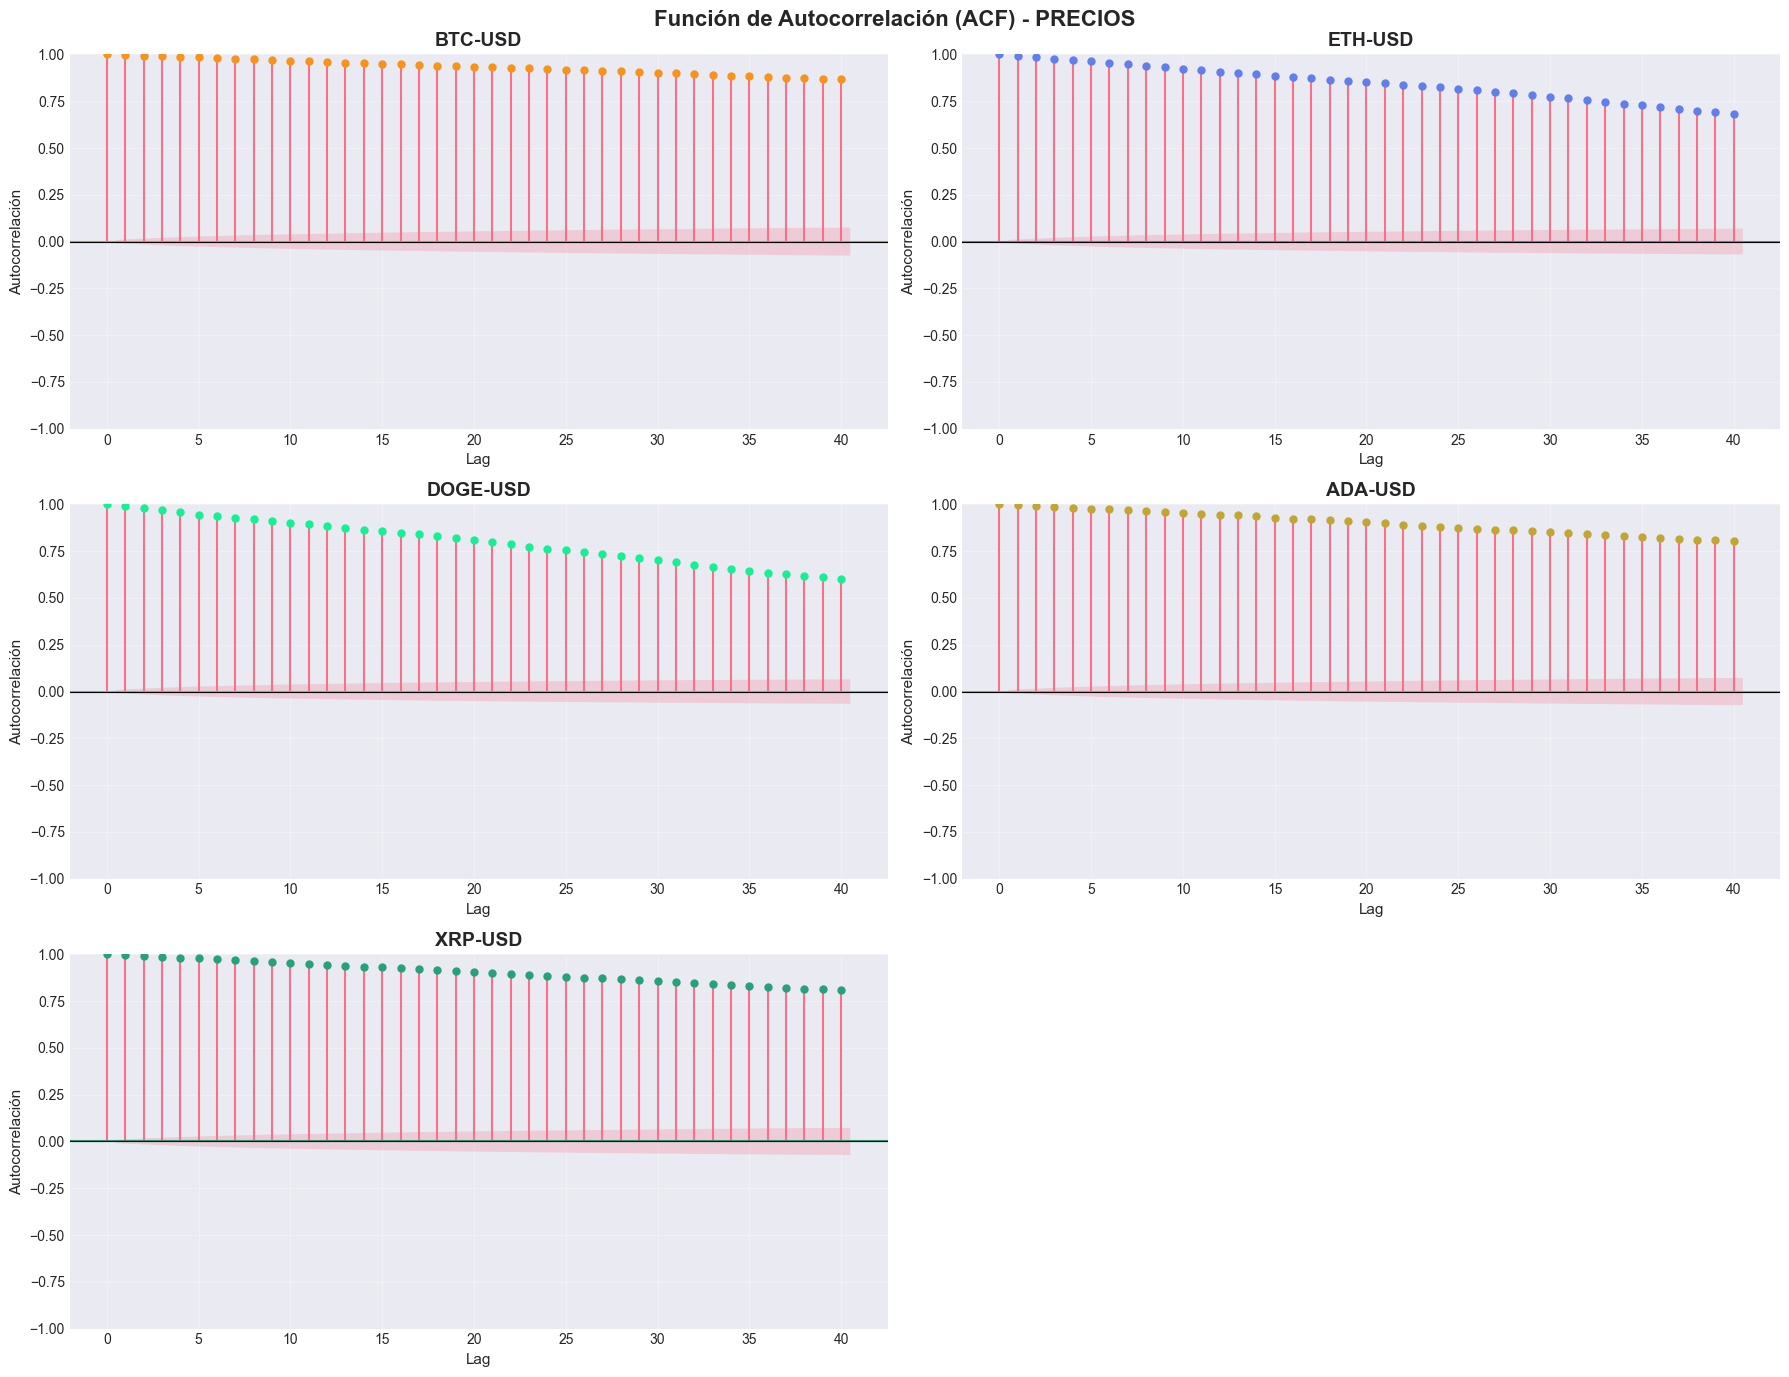


üí° INTERPRETACI√ìN ACF de PRECIOS:
   ‚úÖ Si ACF decae MUY lentamente ‚Üí Random Walk confirmado
   ‚úÖ ACF cercano a 1 en todos los lags ‚Üí No estacionaria
   ‚úÖ Esto confirma los resultados del Test ADF

üìä Valores ACF de PRECIOS (primeros 5 lags):

BTC-USD:
   ACF(lag 1): 0.9969
   ACF(lag 2): 0.9938
   ACF(lag 3): 0.9906
   ACF(lag 4): 0.9874
   ACF(lag 5): 0.9843

ETH-USD:
   ACF(lag 1): 0.9924
   ACF(lag 2): 0.9852
   ACF(lag 3): 0.9778
   ACF(lag 4): 0.9703
   ACF(lag 5): 0.9629

DOGE-USD:
   ACF(lag 1): 0.9893
   ACF(lag 2): 0.9800
   ACF(lag 3): 0.9694
   ACF(lag 4): 0.9577
   ACF(lag 5): 0.9456

ADA-USD:
   ACF(lag 1): 0.9947
   ACF(lag 2): 0.9903
   ACF(lag 3): 0.9857
   ACF(lag 4): 0.9817
   ACF(lag 5): 0.9774

XRP-USD:
   ACF(lag 1): 0.9955
   ACF(lag 2): 0.9912
   ACF(lag 3): 0.9870
   ACF(lag 4): 0.9829
   ACF(lag 5): 0.9785



In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

print("\n" + "="*80)
print("üìà ACF DE PRECIOS - Confirmaci√≥n de Random Walk")
print("="*80)

# Figura 1: ACF de Precios para todas las cryptos
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Funci√≥n de Autocorrelaci√≥n (ACF) - PRECIOS', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    prices = data['Close']
    
    # Plot ACF
    plot_acf(prices, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag', fontsize=11)
    ax.set_ylabel('Autocorrelaci√≥n', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nüí° INTERPRETACI√ìN ACF de PRECIOS:")
print("   ‚úÖ Si ACF decae MUY lentamente ‚Üí Random Walk confirmado")
print("   ‚úÖ ACF cercano a 1 en todos los lags ‚Üí No estacionaria")
print("   ‚úÖ Esto confirma los resultados del Test ADF")

# Calcular ACF num√©ricamente para los primeros lags
print("\nüìä Valores ACF de PRECIOS (primeros 5 lags):\n")
acf_prices_summary = []

for crypto, data in crypto_data.items():
    prices = data['Close']
    acf_values = acf(prices, nlags=5)
    
    print(f"{crypto}:")
    for lag in range(1, 6):
        print(f"   ACF(lag {lag}): {acf_values[lag]:.4f}")
    print()


üìâ ACF DE RETURNS - Test de Predictibilidad


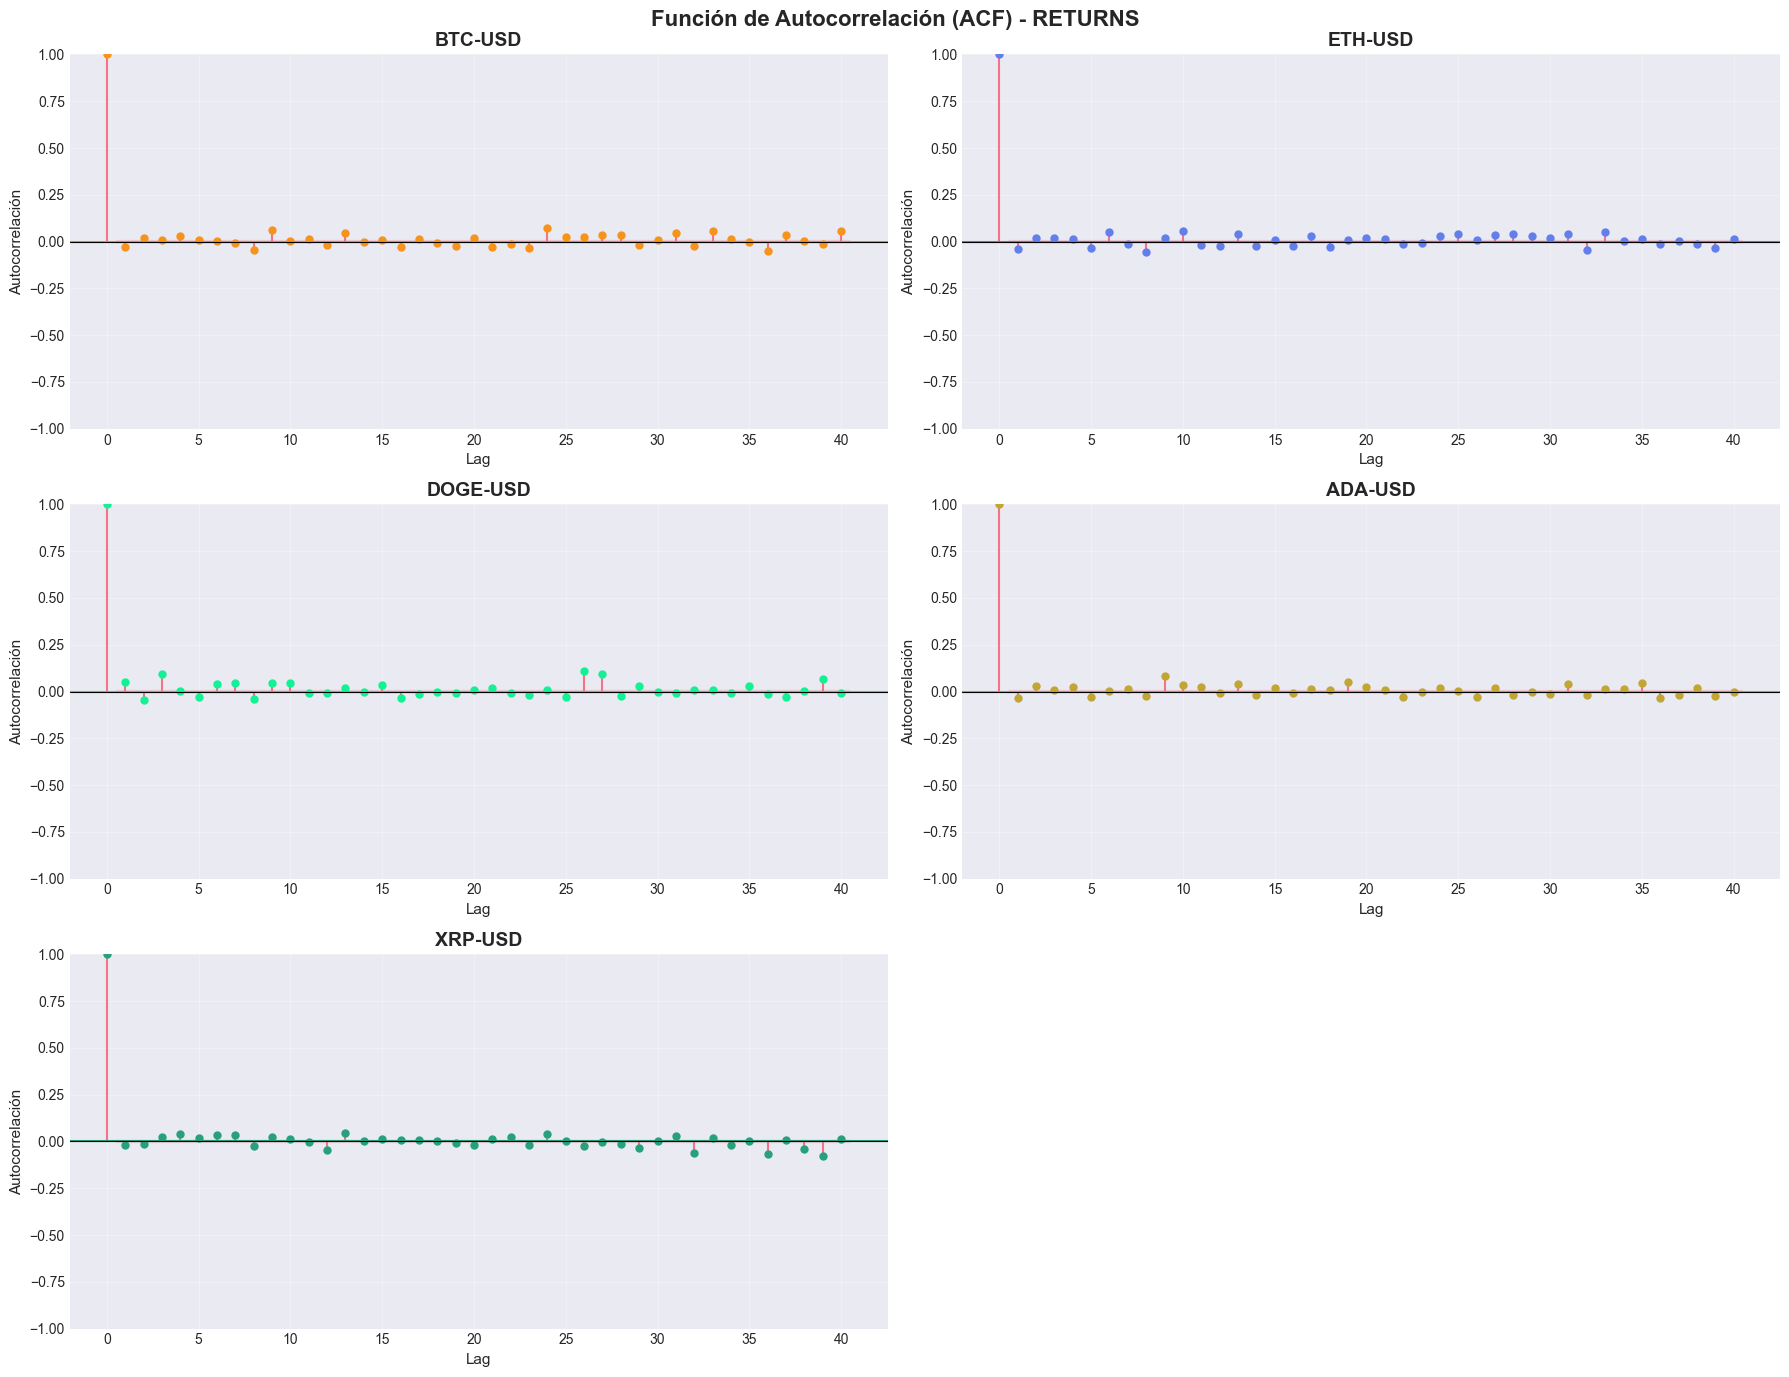


üí° INTERPRETACI√ìN ACF de RETURNS:
   ‚úÖ Si ACF ‚âà 0 para todos los lags ‚Üí Returns NO son predecibles
   ‚úÖ Confirma que no hay memoria en los returns
   ‚úÖ Consistente con Efficient Market Hypothesis

üìä Valores ACF de RETURNS (primeros 10 lags):

BTC-USD:
   Lags con ACF > 0.05: lag 9: 0.0641

ETH-USD:
   Lags con ACF > 0.05: lag 6: 0.0515, lag 8: -0.0569, lag 10: 0.0572

DOGE-USD:
   Lags con ACF > 0.05: lag 1: 0.0504, lag 3: 0.0942

ADA-USD:
   Lags con ACF > 0.05: lag 9: 0.0831

XRP-USD:
   ‚úÖ Todos los lags tienen ACF ‚âà 0 (< 0.05)



In [34]:
from statsmodels.tsa.stattools import acf
print("\n" + "="*80)
print("üìâ ACF DE RETURNS - Test de Predictibilidad")
print("="*80)

# Figura 2: ACF de Returns
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Funci√≥n de Autocorrelaci√≥n (ACF) - RETURNS', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    returns = returns_df['Simple_Return'].dropna()
    
    # Plot ACF
    plot_acf(returns, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag', fontsize=11)
    ax.set_ylabel('Autocorrelaci√≥n', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nüí° INTERPRETACI√ìN ACF de RETURNS:")
print("   ‚úÖ Si ACF ‚âà 0 para todos los lags ‚Üí Returns NO son predecibles")
print("   ‚úÖ Confirma que no hay memoria en los returns")
print("   ‚úÖ Consistente con Efficient Market Hypothesis")

# Calcular ACF num√©ricamente
print("\nüìä Valores ACF de RETURNS (primeros 10 lags):\n")

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    acf_values = acf(returns, nlags=10)
    
    significant_lags = []
    for lag in range(1, 11):
        if abs(acf_values[lag]) > 0.05:  # Umbral de significancia pr√°ctica
            significant_lags.append(f"lag {lag}: {acf_values[lag]:.4f}")
    
    print(f"{crypto}:")
    if significant_lags:
        print(f"   Lags con ACF > 0.05: {', '.join(significant_lags)}")
    else:
        print(f"   ‚úÖ Todos los lags tienen ACF ‚âà 0 (< 0.05)")
    print()


ACF DE RETURNS¬≤ - Detecci√≥n de Volatility Clustering

¬øQU√â ES VOLATILITY CLUSTERING?
   ‚Ä¢ "Per√≠odos de alta volatilidad tienden a agruparse"
   ‚Ä¢ Alta volatilidad HOY ‚Üí Alta volatilidad MA√ëANA (probable)
   ‚Ä¢ Se detecta con ACF de returns¬≤
   ‚Ä¢ Importante para: Gesti√≥n de riesgo, pricing de opciones, VaR



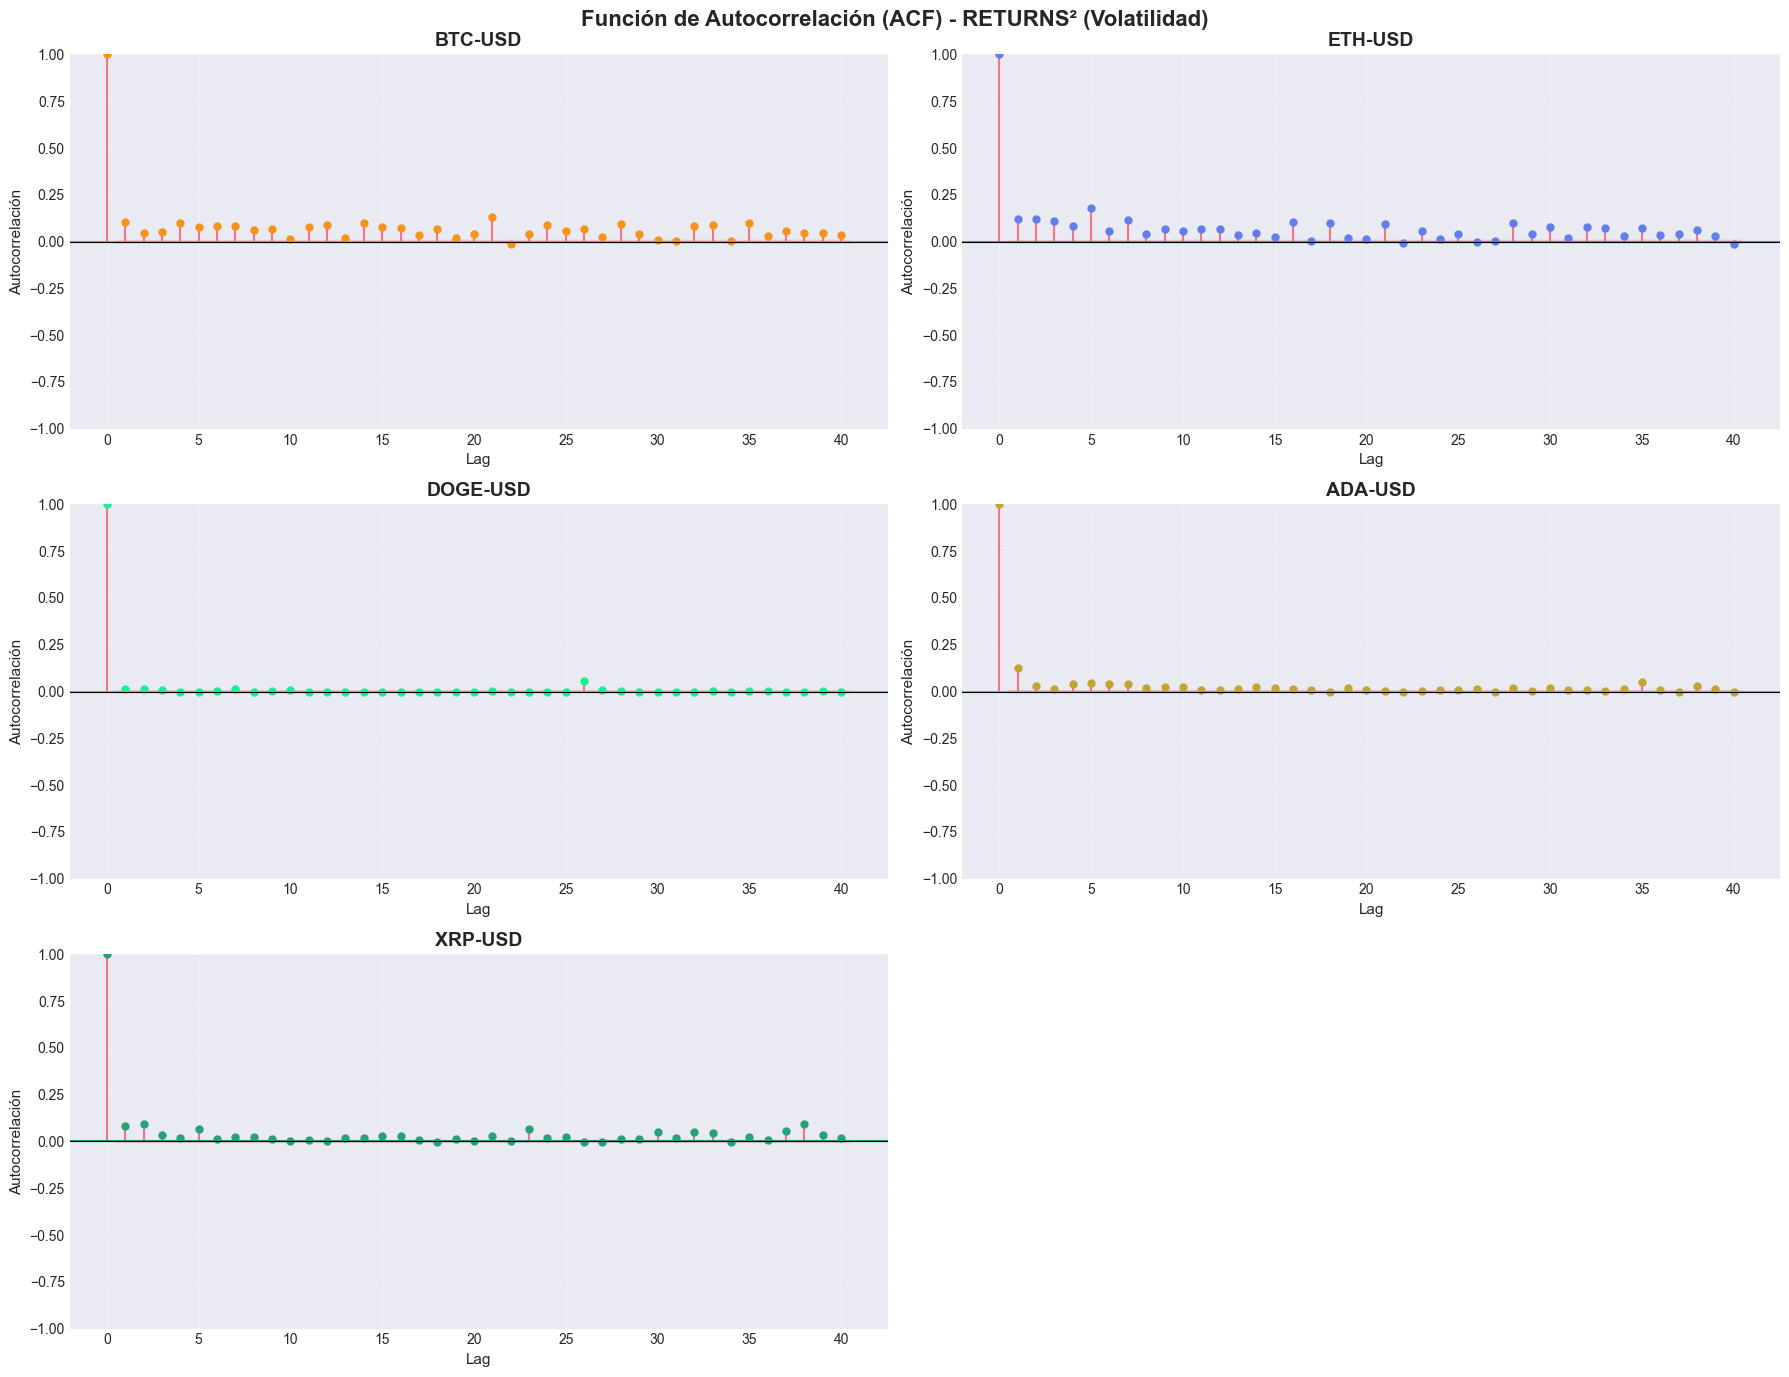


üí° INTERPRETACI√ìN ACF de RETURNS¬≤:
   Si ACF > 0 para varios lags ‚Üí Volatility Clustering presente
   Podemos PREDECIR la volatilidad futura (no el precio)
   Justifica uso de modelos GARCH/ARCH

Valores ACF de RETURNS¬≤ (primeros 10 lags):

BTC-USD:
   Lags significativos (ACF > 0.05): 8/10
   ACF promedio (lags 1-10): 0.0688
   ACF(1): 0.1021
   ACF(5): 0.0769
   ACF(10): 0.0159
   ‚úÖ FUERTE evidencia de Volatility Clustering

ETH-USD:
   Lags significativos (ACF > 0.05): 9/10
   ACF promedio (lags 1-10): 0.0945
   ACF(1): 0.1231
   ACF(5): 0.1805
   ACF(10): 0.0543
   ‚úÖ FUERTE evidencia de Volatility Clustering

DOGE-USD:
   Lags significativos (ACF > 0.05): 0/10
   ACF promedio (lags 1-10): 0.0063
   ACF(1): 0.0136
   ACF(5): -0.0001
   ACF(10): 0.0095
   ‚ùå D√âBIL evidencia de Volatility Clustering

ADA-USD:
   Lags significativos (ACF > 0.05): 1/10
   ACF promedio (lags 1-10): 0.0403
   ACF(1): 0.1234
   ACF(5): 0.0442
   ACF(10): 0.0220
   ‚ùå D√âBIL evidencia de Vola

In [35]:
print("\n" + "="*80)
print("ACF DE RETURNS¬≤ - Detecci√≥n de Volatility Clustering")
print("="*80)

print("""
¬øQU√â ES VOLATILITY CLUSTERING?
   ‚Ä¢ "Per√≠odos de alta volatilidad tienden a agruparse"
   ‚Ä¢ Alta volatilidad HOY ‚Üí Alta volatilidad MA√ëANA (probable)
   ‚Ä¢ Se detecta con ACF de returns¬≤
   ‚Ä¢ Importante para: Gesti√≥n de riesgo, pricing de opciones, VaR
""")

# Figura 3: ACF de Returns¬≤
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Funci√≥n de Autocorrelaci√≥n (ACF) - RETURNS¬≤ (Volatilidad)', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    returns = returns_df['Simple_Return'].dropna()
    returns_squared = returns ** 2
    
    # Plot ACF
    plot_acf(returns_squared, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag', fontsize=11)
    ax.set_ylabel('Autocorrelaci√≥n', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nüí° INTERPRETACI√ìN ACF de RETURNS¬≤:")
print("   Si ACF > 0 para varios lags ‚Üí Volatility Clustering presente")
print("   Podemos PREDECIR la volatilidad futura (no el precio)")
print("   Justifica uso de modelos GARCH/ARCH")

# Calcular ACF num√©ricamente
print("\nValores ACF de RETURNS¬≤ (primeros 10 lags):\n")

acf_returns2_summary = []

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    returns_squared = returns ** 2
    acf_values = acf(returns_squared, nlags=10)
    
    significant_count = sum(1 for lag in range(1, 11) if acf_values[lag] > 0.05)
    avg_acf = np.mean([acf_values[lag] for lag in range(1, 11)])
    
    print(f"{crypto}:")
    print(f"   Lags significativos (ACF > 0.05): {significant_count}/10")
    print(f"   ACF promedio (lags 1-10): {avg_acf:.4f}")
    print(f"   ACF(1): {acf_values[1]:.4f}")
    print(f"   ACF(5): {acf_values[5]:.4f}")
    print(f"   ACF(10): {acf_values[10]:.4f}")
    
    if significant_count >= 5:
        print(f"   ‚úÖ FUERTE evidencia de Volatility Clustering")
    elif significant_count >= 3:
        print(f"   ‚ö†Ô∏è  MODERADA evidencia de Volatility Clustering")
    else:
        print(f"   ‚ùå D√âBIL evidencia de Volatility Clustering")
    print()
    
    acf_returns2_summary.append({
        'Crypto': crypto,
        'ACF_1': acf_values[1],
        'ACF_5': acf_values[5],
        'ACF_10': acf_values[10],
        'Avg_ACF': avg_acf,
        'Significant_Lags': significant_count
    })


üìä COMPARACI√ìN VISUAL: ACF de Precios, Returns y Returns¬≤


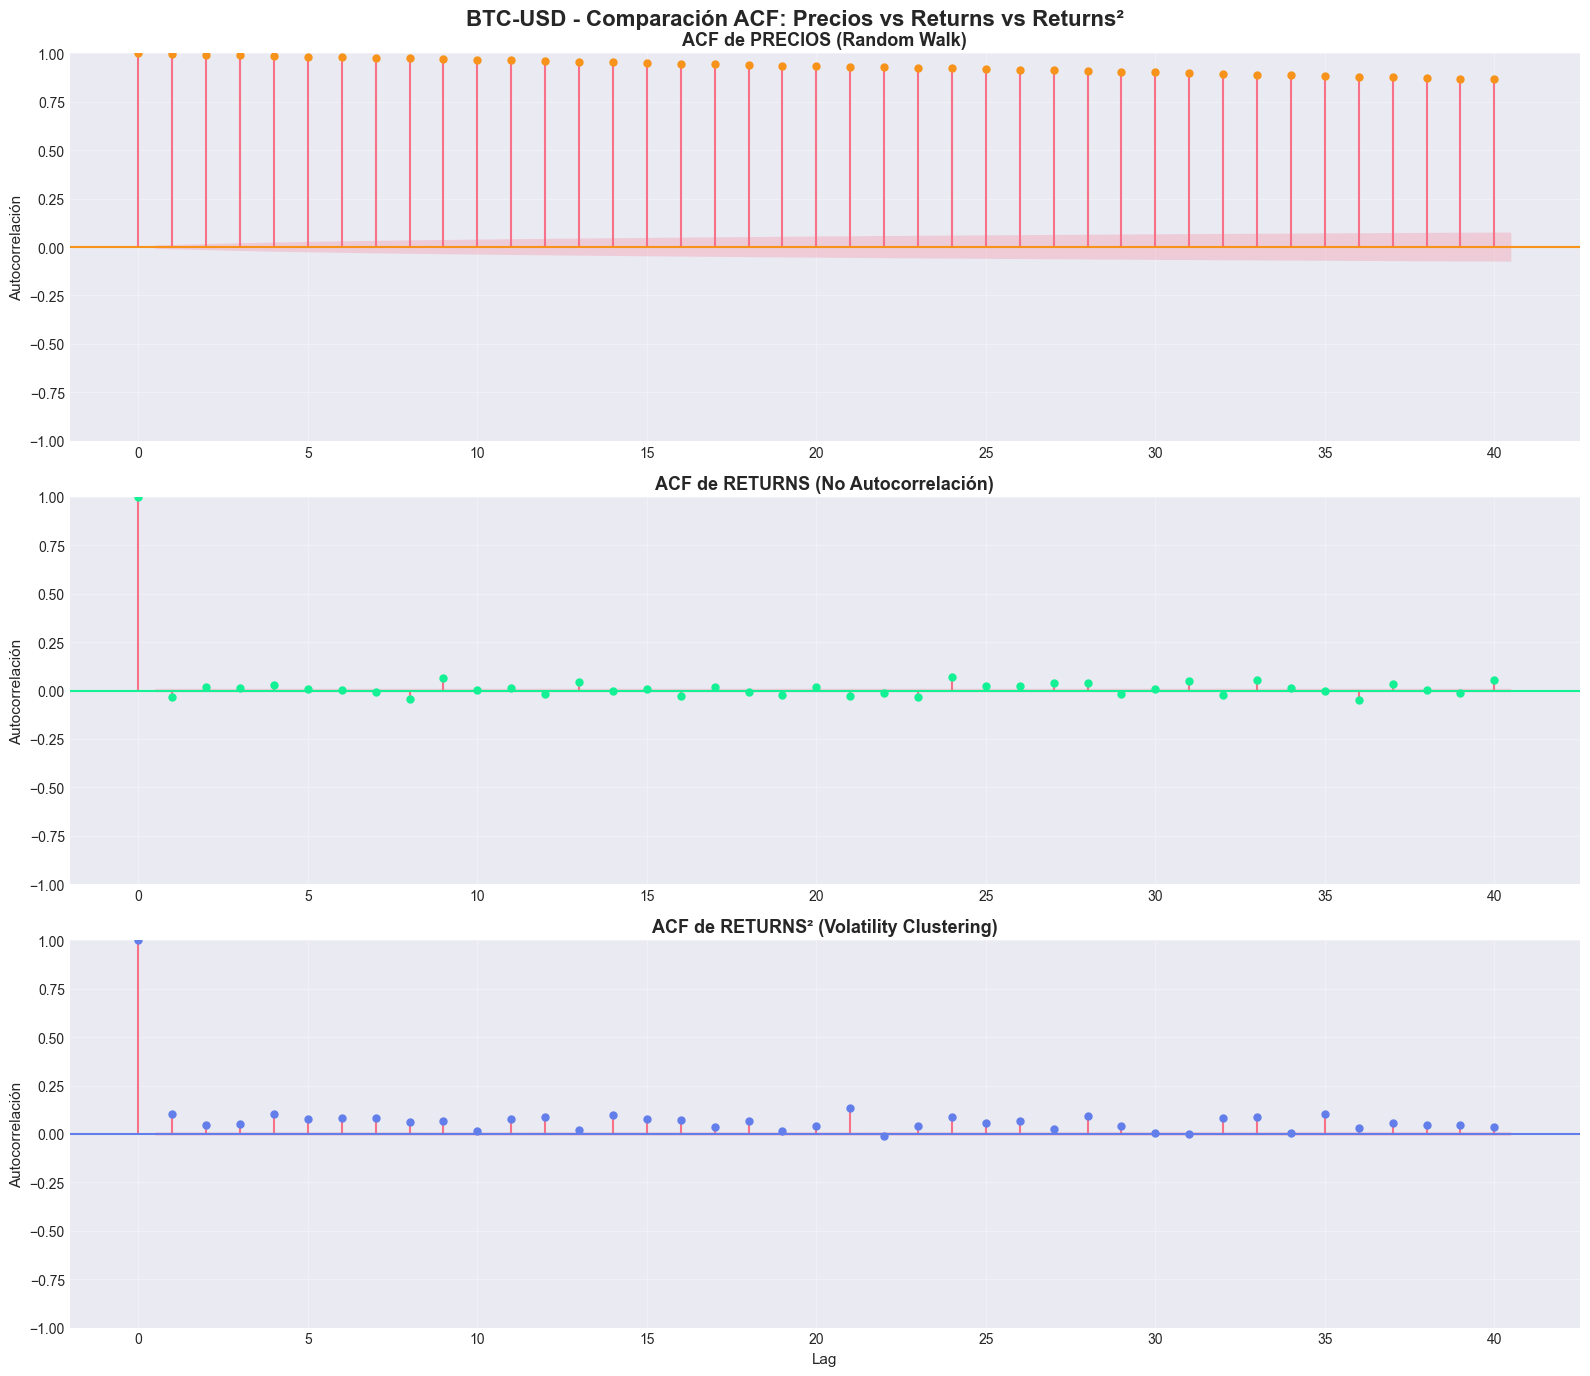

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

print("\n" + "="*80)
print("üìä COMPARACI√ìN VISUAL: ACF de Precios, Returns y Returns¬≤")
print("="*80)

# Seleccionar BTC como ejemplo representativo
crypto_example = 'BTC-USD'
example_prices = crypto_data[crypto_example]['Close']
example_returns = crypto_returns[crypto_example]['Simple_Return'].dropna()
example_returns2 = example_returns ** 2

fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle(f'{crypto_example} - Comparaci√≥n ACF: Precios vs Returns vs Returns¬≤', 
             fontsize=16, fontweight='bold')

# ACF Precios
plot_acf(example_prices, lags=40, ax=axes[0], color='#F7931A', alpha=0.7)
axes[0].set_title('ACF de PRECIOS (Random Walk)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Autocorrelaci√≥n', fontsize=11)
axes[0].grid(True, alpha=0.3)

# ACF Returns
plot_acf(example_returns, lags=40, ax=axes[1], color='#14F195', alpha=0.7)
axes[1].set_title('ACF de RETURNS (No Autocorrelaci√≥n)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Autocorrelaci√≥n', fontsize=11)
axes[1].grid(True, alpha=0.3)

# ACF Returns¬≤
plot_acf(example_returns2, lags=40, ax=axes[2], color='#627EEA', alpha=0.7)
axes[2].set_title('ACF de RETURNS¬≤ (Volatility Clustering)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Lag', fontsize=11)
axes[2].set_ylabel('Autocorrelaci√≥n', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
print("\n" + "="*80)
print("üìä TABLA RESUMEN - VOLATILITY CLUSTERING")
print("="*80)

acf_summary_df = pd.DataFrame(acf_returns2_summary)
print("\n", acf_summary_df.to_string(index=False))


üìä TABLA RESUMEN - VOLATILITY CLUSTERING

   Crypto    ACF_1     ACF_5   ACF_10  Avg_ACF  Significant_Lags
 BTC-USD 0.102083  0.076858 0.015854 0.068783                 8
 ETH-USD 0.123138  0.180486 0.054259 0.094516                 9
DOGE-USD 0.013646 -0.000051 0.009527 0.006313                 0
 ADA-USD 0.123407  0.044201 0.022004 0.040270                 1
 XRP-USD 0.084718  0.067088 0.002511 0.037292                 3


In [38]:
print("\n" + "="*80)
print("üí° RESUMEN DE HALLAZGOS - AN√ÅLISIS ACF")
print("="*80)

print("""
‚úÖ CONFIRMACI√ìN DE HIP√ìTESIS:

1. PRECIOS:
   ‚úì ACF muy alto (~0.99) y decae lentamente
   ‚úì Confirma que son RANDOM WALKS
   ‚úì Consistente con Test ADF
   
2. RETURNS:
   ‚úì ACF ‚âà 0 para todos los lags
   ‚úì NO hay autocorrelaci√≥n significativa
   ‚úì Returns son IMPREDECIBLES
   ‚úì Confirma Efficient Market Hypothesis
   
3. RETURNS¬≤ (Volatilidad):
   ‚úì ACF significativamente > 0
   ‚úì VOLATILITY CLUSTERING presente
   ‚úì Alta volatilidad persiste en el tiempo
   ‚úì Justifica modelos GARCH

üìä IMPLICACIONES PR√ÅCTICAS:

‚ùå NO PUEDES PREDECIR:
   ‚Ä¢ Direcci√≥n del precio (subir/bajar)
   ‚Ä¢ Magnitud exacta del return
   ‚Ä¢ Timing de compra/venta basado solo en historia

‚úÖ S√ç PUEDES PREDECIR/MODELAR:
   ‚Ä¢ Volatilidad futura (usando returns¬≤)
   ‚Ä¢ Per√≠odos de alto riesgo
   ‚Ä¢ Rangos de variaci√≥n esperados
   ‚Ä¢ Value at Risk (VaR)

üíº ESTRATEGIAS VIABLES:
   ‚Ä¢ Gesti√≥n de riesgo din√°mica (ajustar posiciones por volatilidad)
   ‚Ä¢ Diversificaci√≥n temporal (rebalanceo)
   ‚Ä¢ Hedging en per√≠odos de alta volatilidad
   ‚Ä¢ Opciones y derivados (modelar volatilidad)

üö´ ESTRATEGIAS NO VIABLES:
   ‚Ä¢ Market timing basado solo en precios pasados
   ‚Ä¢ An√°lisis t√©cnico puro (sin fundamentos)
   ‚Ä¢ Day trading sin gesti√≥n de riesgo

üìö CONCLUSI√ìN ACAD√âMICA:
   "Los mercados de criptomonedas son informationally efficient 
   (precios random walk) pero volatility inefficient (clustering),
   lo cual es consistente con la literatura moderna de finanzas."
""")

print("\n" + "="*80)
print("üéØ RESPUESTA FINAL A LAS PREGUNTAS DE NEGOCIO")
print("="*80)

print("""
‚ùì ¬øSon las cryptos inversiones predecibles o aleatorias?

RESPUESTA COMPLETA:

1. PRECIOS: ALEATORIOS (Random Walk)
   ‚Üí No puedes predecir el precio futuro solo con historia
   ‚Üí Consistente con mercados eficientes
   
2. RETURNS: ALEATORIOS (No autocorrelaci√≥n)
   ‚Üí No puedes predecir si subir√° o bajar√° ma√±ana
   ‚Üí El mejor predictor de ma√±ana es "no cambio"
   
3. VOLATILIDAD: PREDECIBLE (Clustering)
   ‚Üí S√ç puedes predecir cu√°nto variar√° (no direcci√≥n)
   ‚Üí Alta volatilidad hoy ‚Üí Alta volatilidad ma√±ana
   
üí° MET√ÅFORA:
   Es como el clima:
   ‚Ä¢ No puedes predecir la temperatura exacta de ma√±ana
   ‚Ä¢ Pero S√ç puedes predecir si ser√° un d√≠a "vol√°til" o "estable"

üéØ PARA EL INVERSIONISTA RETAIL:
   ‚Ä¢ Enf√≥cate en: Horizonte largo plazo, diversificaci√≥n, gesti√≥n de riesgo
   ‚Ä¢ Evita: Intentar "timing the market" con an√°lisis t√©cnico puro
   ‚Ä¢ Considera: Dollar-cost averaging, rebalanceo, stop-losses din√°micos
""")



üí° RESUMEN DE HALLAZGOS - AN√ÅLISIS ACF

‚úÖ CONFIRMACI√ìN DE HIP√ìTESIS:

1. PRECIOS:
   ‚úì ACF muy alto (~0.99) y decae lentamente
   ‚úì Confirma que son RANDOM WALKS
   ‚úì Consistente con Test ADF

2. RETURNS:
   ‚úì ACF ‚âà 0 para todos los lags
   ‚úì NO hay autocorrelaci√≥n significativa
   ‚úì Returns son IMPREDECIBLES
   ‚úì Confirma Efficient Market Hypothesis

3. RETURNS¬≤ (Volatilidad):
   ‚úì ACF significativamente > 0
   ‚úì VOLATILITY CLUSTERING presente
   ‚úì Alta volatilidad persiste en el tiempo
   ‚úì Justifica modelos GARCH

üìä IMPLICACIONES PR√ÅCTICAS:

‚ùå NO PUEDES PREDECIR:
   ‚Ä¢ Direcci√≥n del precio (subir/bajar)
   ‚Ä¢ Magnitud exacta del return
   ‚Ä¢ Timing de compra/venta basado solo en historia

‚úÖ S√ç PUEDES PREDECIR/MODELAR:
   ‚Ä¢ Volatilidad futura (usando returns¬≤)
   ‚Ä¢ Per√≠odos de alto riesgo
   ‚Ä¢ Rangos de variaci√≥n esperados
   ‚Ä¢ Value at Risk (VaR)

üíº ESTRATEGIAS VIABLES:
   ‚Ä¢ Gesti√≥n de riesgo din√°mica (ajustar posicion

In [39]:
print("="*80)
print(" AN√ÅLISIS DE VOLATILIDAD Y CLUSTERING")
print("="*80)

print("""
üéØ OBJETIVO FINAL: Analizar la volatilidad en el tiempo y detectar clustering

üìö CONCEPTOS CLAVE:

1. VOLATILIDAD:
   ‚Ä¢ Medida de variabilidad de returns
   ‚Ä¢ Alta volatilidad = Alto riesgo
   ‚Ä¢ Se calcula t√≠picamente como desviaci√≥n est√°ndar de returns
   
2. ROLLING VOLATILITY:
   ‚Ä¢ Volatilidad calculada en ventanas m√≥viles (ej: 30 d√≠as)
   ‚Ä¢ Permite ver c√≥mo cambia el riesgo en el tiempo
   ‚Ä¢ √ötil para ajustar estrategias din√°micamente
   
3. VOLATILITY CLUSTERING:
   ‚Ä¢ "Per√≠odos vol√°tiles tienden a seguir per√≠odos vol√°tiles"
   ‚Ä¢ "Per√≠odos tranquilos tienden a seguir per√≠odos tranquilos"
   ‚Ä¢ Observado por Benoit Mandelbrot (1963)
   
4. IMPLICACIONES:
   ‚Ä¢ Gesti√≥n de riesgo din√°mica
   ‚Ä¢ Ajuste de posiciones seg√∫n volatilidad
   ‚Ä¢ Pricing de opciones y derivados
   ‚Ä¢ Value at Risk (VaR) condicional
""")

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

 AN√ÅLISIS DE VOLATILIDAD Y CLUSTERING

üéØ OBJETIVO FINAL: Analizar la volatilidad en el tiempo y detectar clustering

üìö CONCEPTOS CLAVE:

1. VOLATILIDAD:
   ‚Ä¢ Medida de variabilidad de returns
   ‚Ä¢ Alta volatilidad = Alto riesgo
   ‚Ä¢ Se calcula t√≠picamente como desviaci√≥n est√°ndar de returns

2. ROLLING VOLATILITY:
   ‚Ä¢ Volatilidad calculada en ventanas m√≥viles (ej: 30 d√≠as)
   ‚Ä¢ Permite ver c√≥mo cambia el riesgo en el tiempo
   ‚Ä¢ √ötil para ajustar estrategias din√°micamente

3. VOLATILITY CLUSTERING:
   ‚Ä¢ "Per√≠odos vol√°tiles tienden a seguir per√≠odos vol√°tiles"
   ‚Ä¢ "Per√≠odos tranquilos tienden a seguir per√≠odos tranquilos"
   ‚Ä¢ Observado por Benoit Mandelbrot (1963)

4. IMPLICACIONES:
   ‚Ä¢ Gesti√≥n de riesgo din√°mica
   ‚Ä¢ Ajuste de posiciones seg√∫n volatilidad
   ‚Ä¢ Pricing de opciones y derivados
   ‚Ä¢ Value at Risk (VaR) condicional



In [40]:
print("\n" + "="*80)
print("üìä CALCULANDO ROLLING VOLATILITY")
print("="*80)

# Par√°metros
window_sizes = [7, 30, 90]  # 1 semana, 1 mes, 3 meses

# Diccionario para guardar volatilidades
rolling_volatility = {}

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return']
    
    vol_data = {
        'Date': returns_df['Date'],
        'Returns': returns
    }
    
    # Calcular volatilidad para cada ventana
    for window in window_sizes:
        vol_data[f'Vol_{window}d'] = returns.rolling(window=window).std()
    
    rolling_volatility[crypto] = pd.DataFrame(vol_data)
    
    print(f"‚úÖ {crypto}: Rolling volatility calculada para ventanas de {window_sizes}")


üìä CALCULANDO ROLLING VOLATILITY
‚úÖ BTC-USD: Rolling volatility calculada para ventanas de [7, 30, 90]
‚úÖ ETH-USD: Rolling volatility calculada para ventanas de [7, 30, 90]
‚úÖ DOGE-USD: Rolling volatility calculada para ventanas de [7, 30, 90]
‚úÖ ADA-USD: Rolling volatility calculada para ventanas de [7, 30, 90]
‚úÖ XRP-USD: Rolling volatility calculada para ventanas de [7, 30, 90]



üìà VISUALIZACI√ìN: PRECIOS Y VOLATILIDAD EN EL TIEMPO


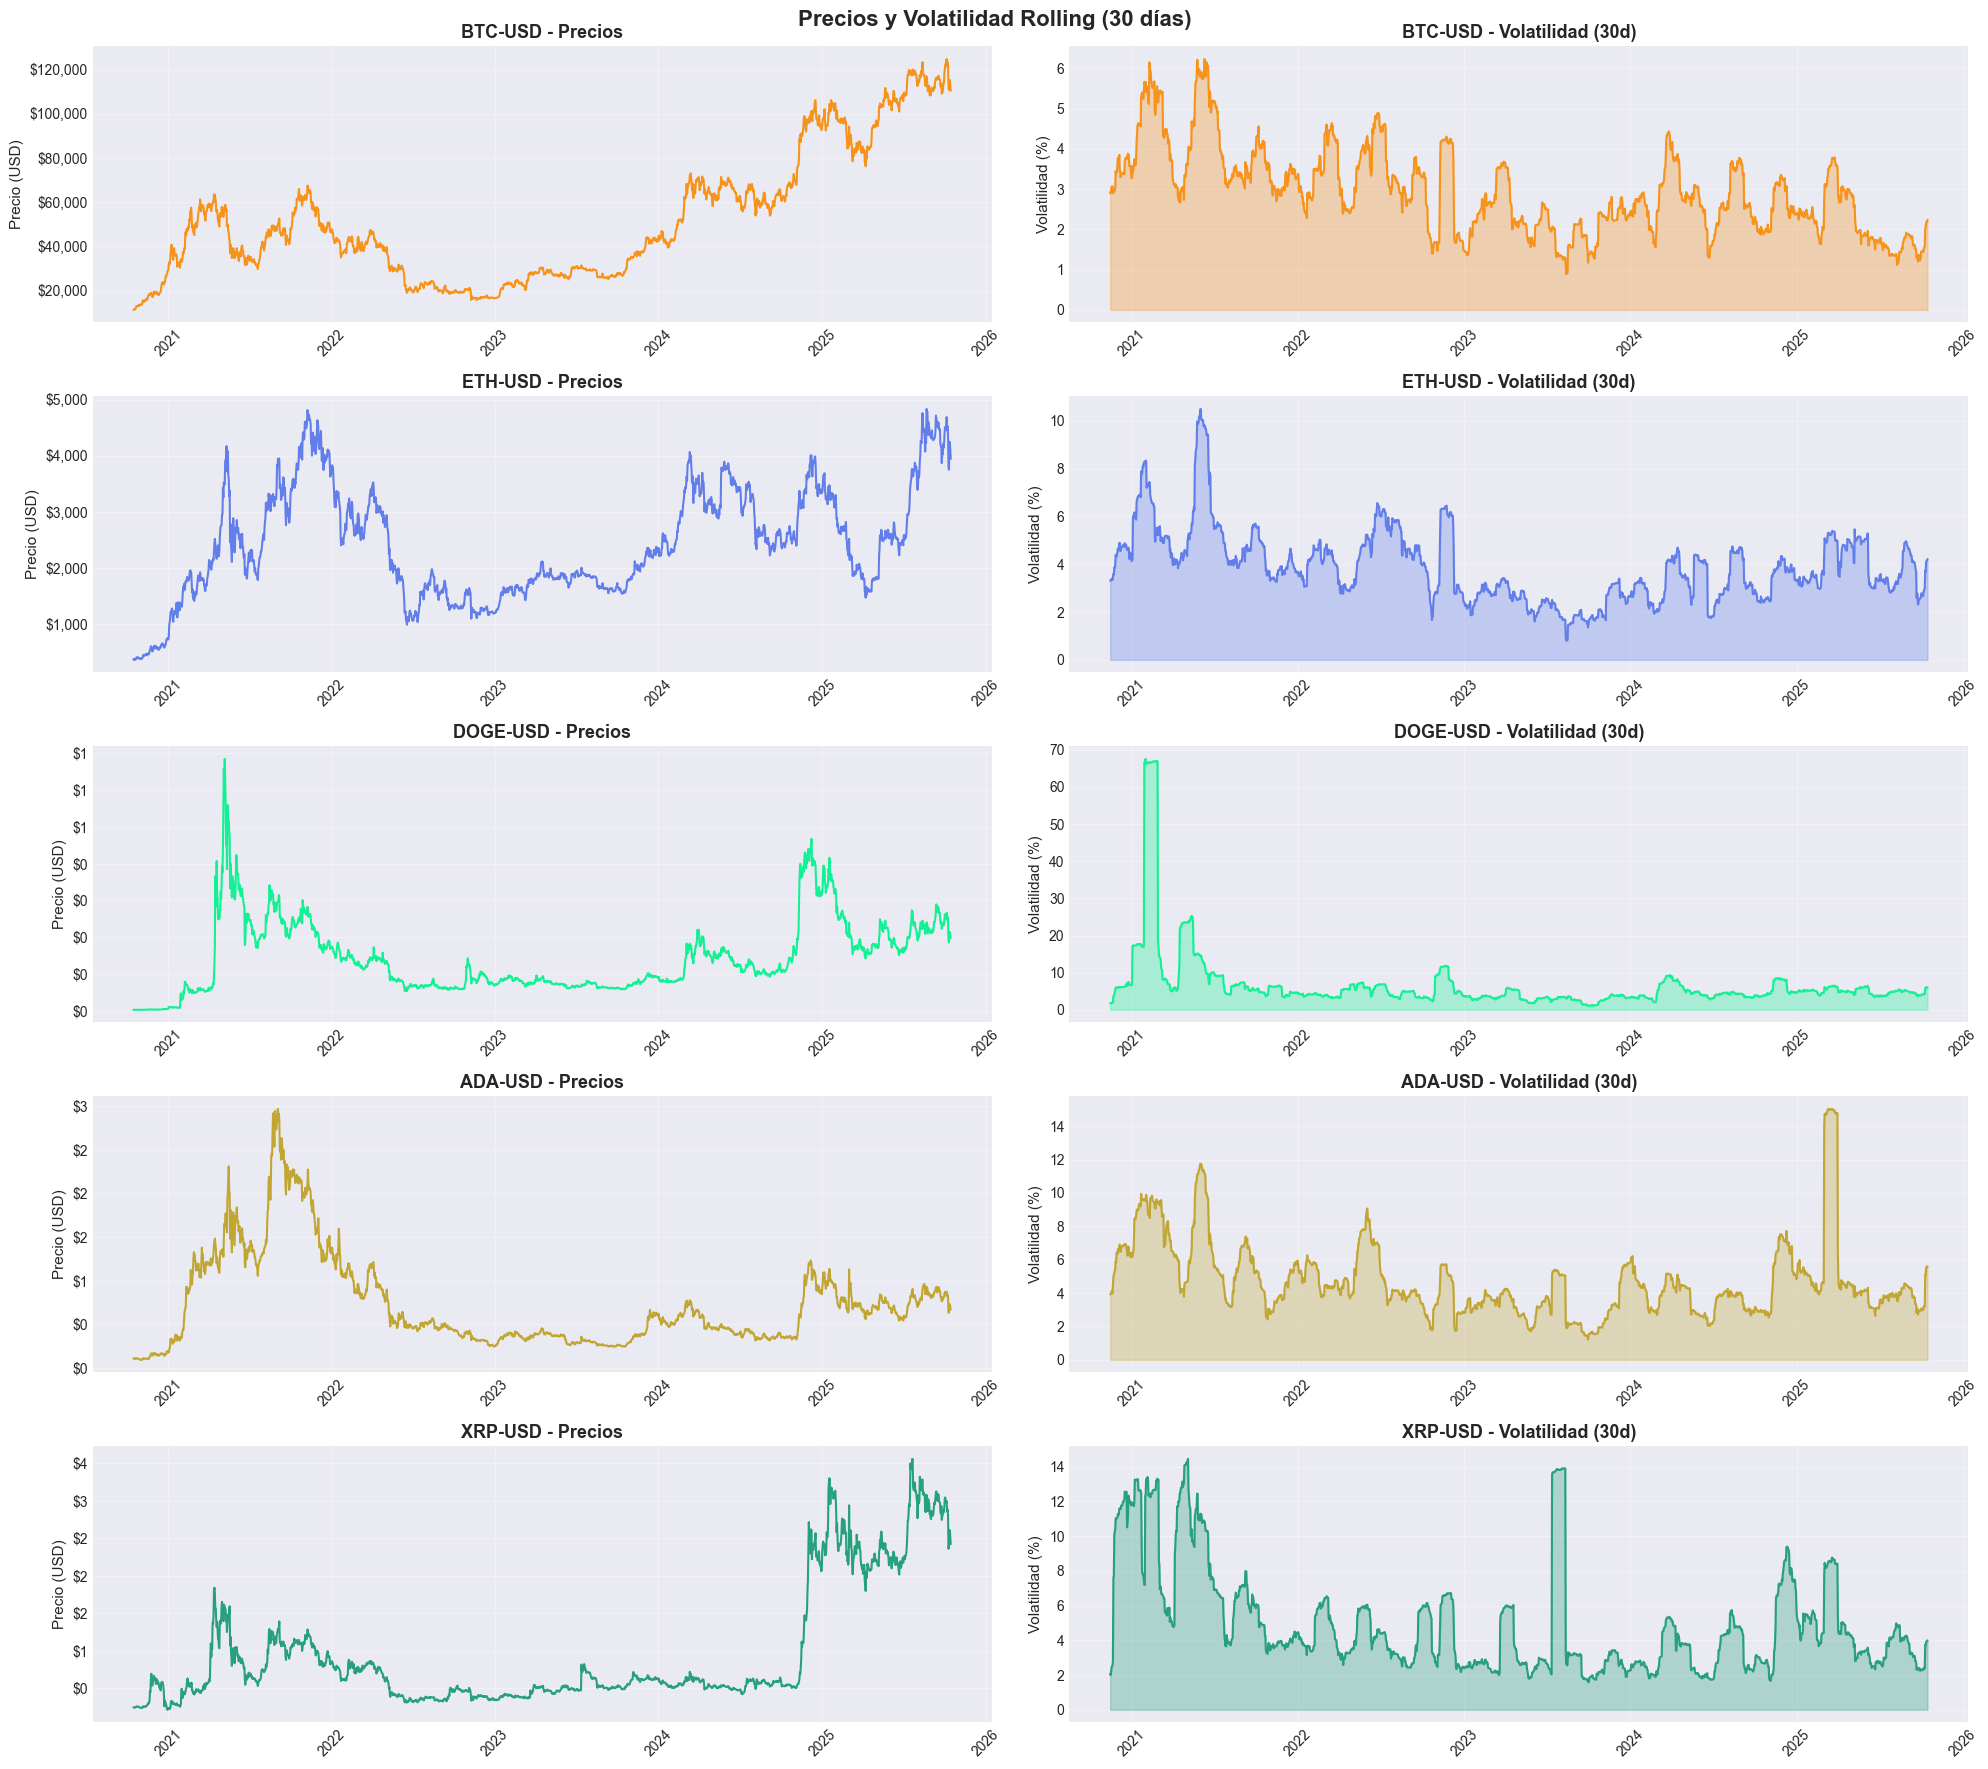

In [41]:
print("\n" + "="*80)
print("üìà VISUALIZACI√ìN: PRECIOS Y VOLATILIDAD EN EL TIEMPO")
print("="*80)

# Figura 1: Precios + Rolling Volatility (30 d√≠as)
fig, axes = plt.subplots(5, 2, figsize=(20, 18))
fig.suptitle('Precios y Volatilidad Rolling (30 d√≠as)', fontsize=16, fontweight='bold')

for idx, (crypto, data) in enumerate(crypto_data.items()):
    # Subplot para PRECIOS
    ax1 = axes[idx, 0]
    ax1.plot(data['Date'], data['Close'], color=colors[idx], linewidth=1.5)
    ax1.set_title(f'{crypto} - Precios', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Precio (USD)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Subplot para VOLATILIDAD
    ax2 = axes[idx, 1]
    vol_data = rolling_volatility[crypto]
    ax2.plot(vol_data['Date'], vol_data['Vol_30d'], color=colors[idx], linewidth=1.5)
    ax2.fill_between(vol_data['Date'], vol_data['Vol_30d'], alpha=0.3, color=colors[idx])
    ax2.set_title(f'{crypto} - Volatilidad (30d)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Volatilidad (%)', fontsize=11)
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


üìä COMPARACI√ìN: DIFERENTES VENTANAS DE TIEMPO


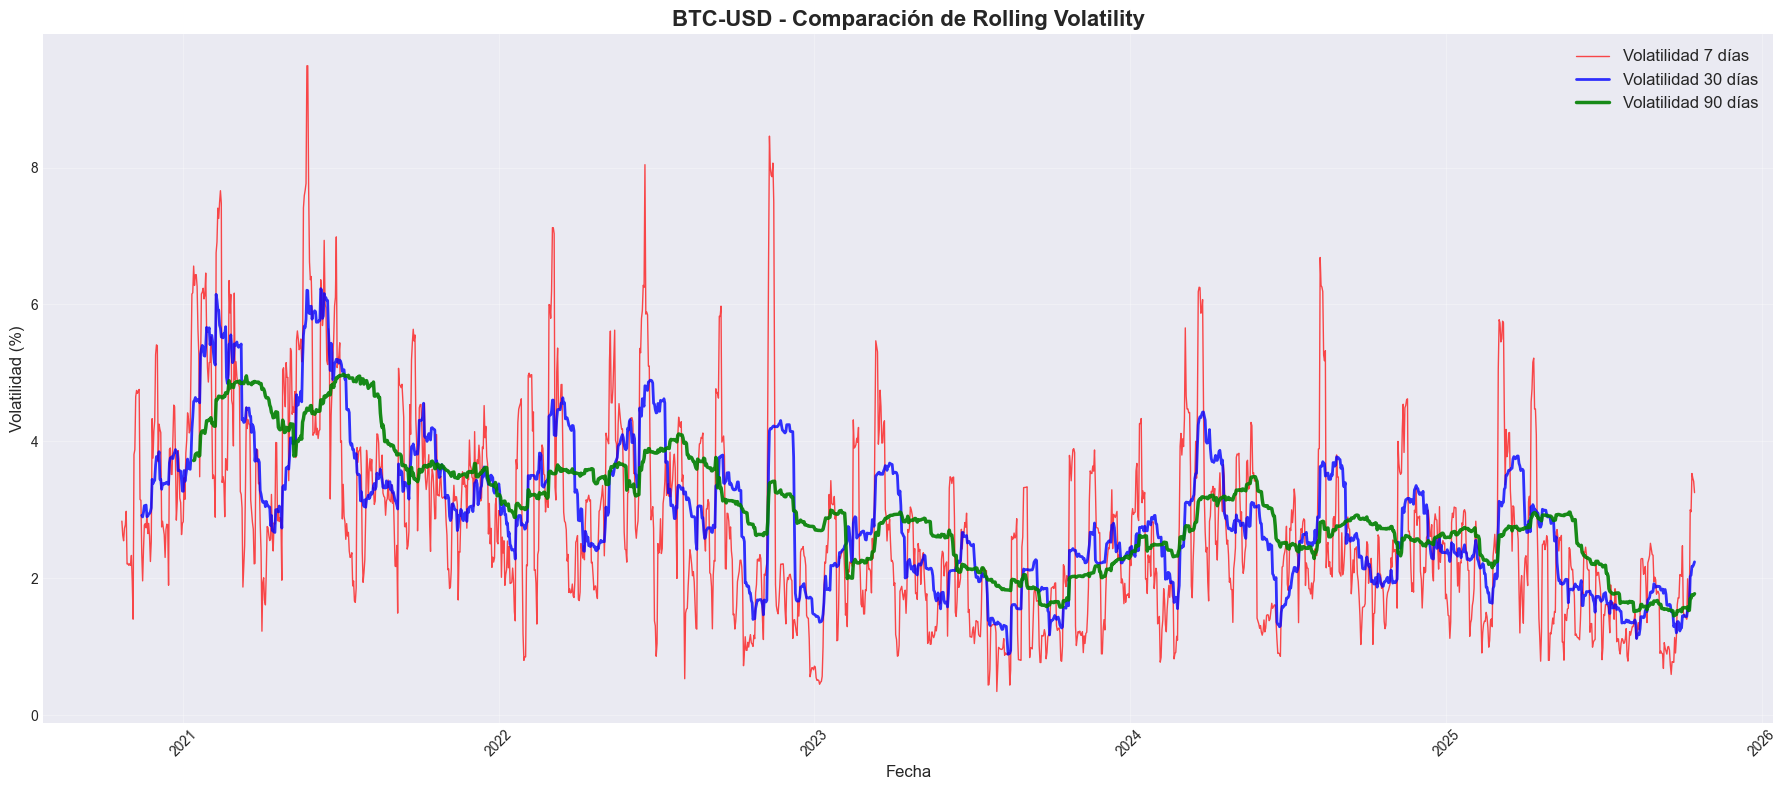


üí° OBSERVACI√ìN:
   ‚Ä¢ Ventana corta (7d): M√°s reactiva, captura cambios r√°pidos
   ‚Ä¢ Ventana media (30d): Balance entre reactividad y suavizado
   ‚Ä¢ Ventana larga (90d): M√°s suave, muestra tendencias de largo plazo


In [42]:
print("\n" + "="*80)
print("üìä COMPARACI√ìN: DIFERENTES VENTANAS DE TIEMPO")
print("="*80)

# Seleccionar BTC como ejemplo
crypto_example = 'BTC-USD'
vol_example = rolling_volatility[crypto_example]

fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(vol_example['Date'], vol_example['Vol_7d'], 
        label='Volatilidad 7 d√≠as', linewidth=1, alpha=0.7, color='red')
ax.plot(vol_example['Date'], vol_example['Vol_30d'], 
        label='Volatilidad 30 d√≠as', linewidth=2, alpha=0.8, color='blue')
ax.plot(vol_example['Date'], vol_example['Vol_90d'], 
        label='Volatilidad 90 d√≠as', linewidth=2.5, alpha=0.9, color='green')

ax.set_title(f'{crypto_example} - Comparaci√≥n de Rolling Volatility', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Volatilidad (%)', fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

print("\nüí° OBSERVACI√ìN:")
print("   ‚Ä¢ Ventana corta (7d): M√°s reactiva, captura cambios r√°pidos")
print("   ‚Ä¢ Ventana media (30d): Balance entre reactividad y suavizado")
print("   ‚Ä¢ Ventana larga (90d): M√°s suave, muestra tendencias de largo plazo")

In [43]:
print("\n" + "="*80)
print("üî• IDENTIFICACI√ìN DE PER√çODOS DE ALTA VOLATILIDAD")
print("="*80)

# Definir umbrales (percentil 90 como "alta volatilidad")
high_vol_events = []

for crypto, vol_data in rolling_volatility.items():
    vol_30d = vol_data['Vol_30d'].dropna()
    
    # Calcular umbral (percentil 90)
    threshold = vol_30d.quantile(0.90)
    
    # Identificar per√≠odos por encima del umbral
    high_vol_periods = vol_data[vol_data['Vol_30d'] > threshold]
    
    if len(high_vol_periods) > 0:
        print(f"\n{crypto}:")
        print(f"   Umbral 90%: {threshold:.2f}%")
        print(f"   Per√≠odos de alta volatilidad: {len(high_vol_periods)} d√≠as")
        print(f"   Volatilidad m√°xima: {vol_30d.max():.2f}%")
        print(f"   Volatilidad promedio: {vol_30d.mean():.2f}%")



üî• IDENTIFICACI√ìN DE PER√çODOS DE ALTA VOLATILIDAD

BTC-USD:
   Umbral 90%: 4.34%
   Per√≠odos de alta volatilidad: 180 d√≠as
   Volatilidad m√°xima: 6.23%
   Volatilidad promedio: 2.92%

ETH-USD:
   Umbral 90%: 5.61%
   Per√≠odos de alta volatilidad: 180 d√≠as
   Volatilidad m√°xima: 10.49%
   Volatilidad promedio: 3.88%

DOGE-USD:
   Umbral 90%: 9.18%
   Per√≠odos de alta volatilidad: 180 d√≠as
   Volatilidad m√°xima: 67.54%
   Volatilidad promedio: 6.54%

ADA-USD:
   Umbral 90%: 7.31%
   Per√≠odos de alta volatilidad: 180 d√≠as
   Volatilidad m√°xima: 15.03%
   Volatilidad promedio: 4.73%

XRP-USD:
   Umbral 90%: 10.25%
   Per√≠odos de alta volatilidad: 180 d√≠as
   Volatilidad m√°xima: 14.45%
   Volatilidad promedio: 4.93%



üé® VISUALIZACI√ìN DE VOLATILITY CLUSTERING


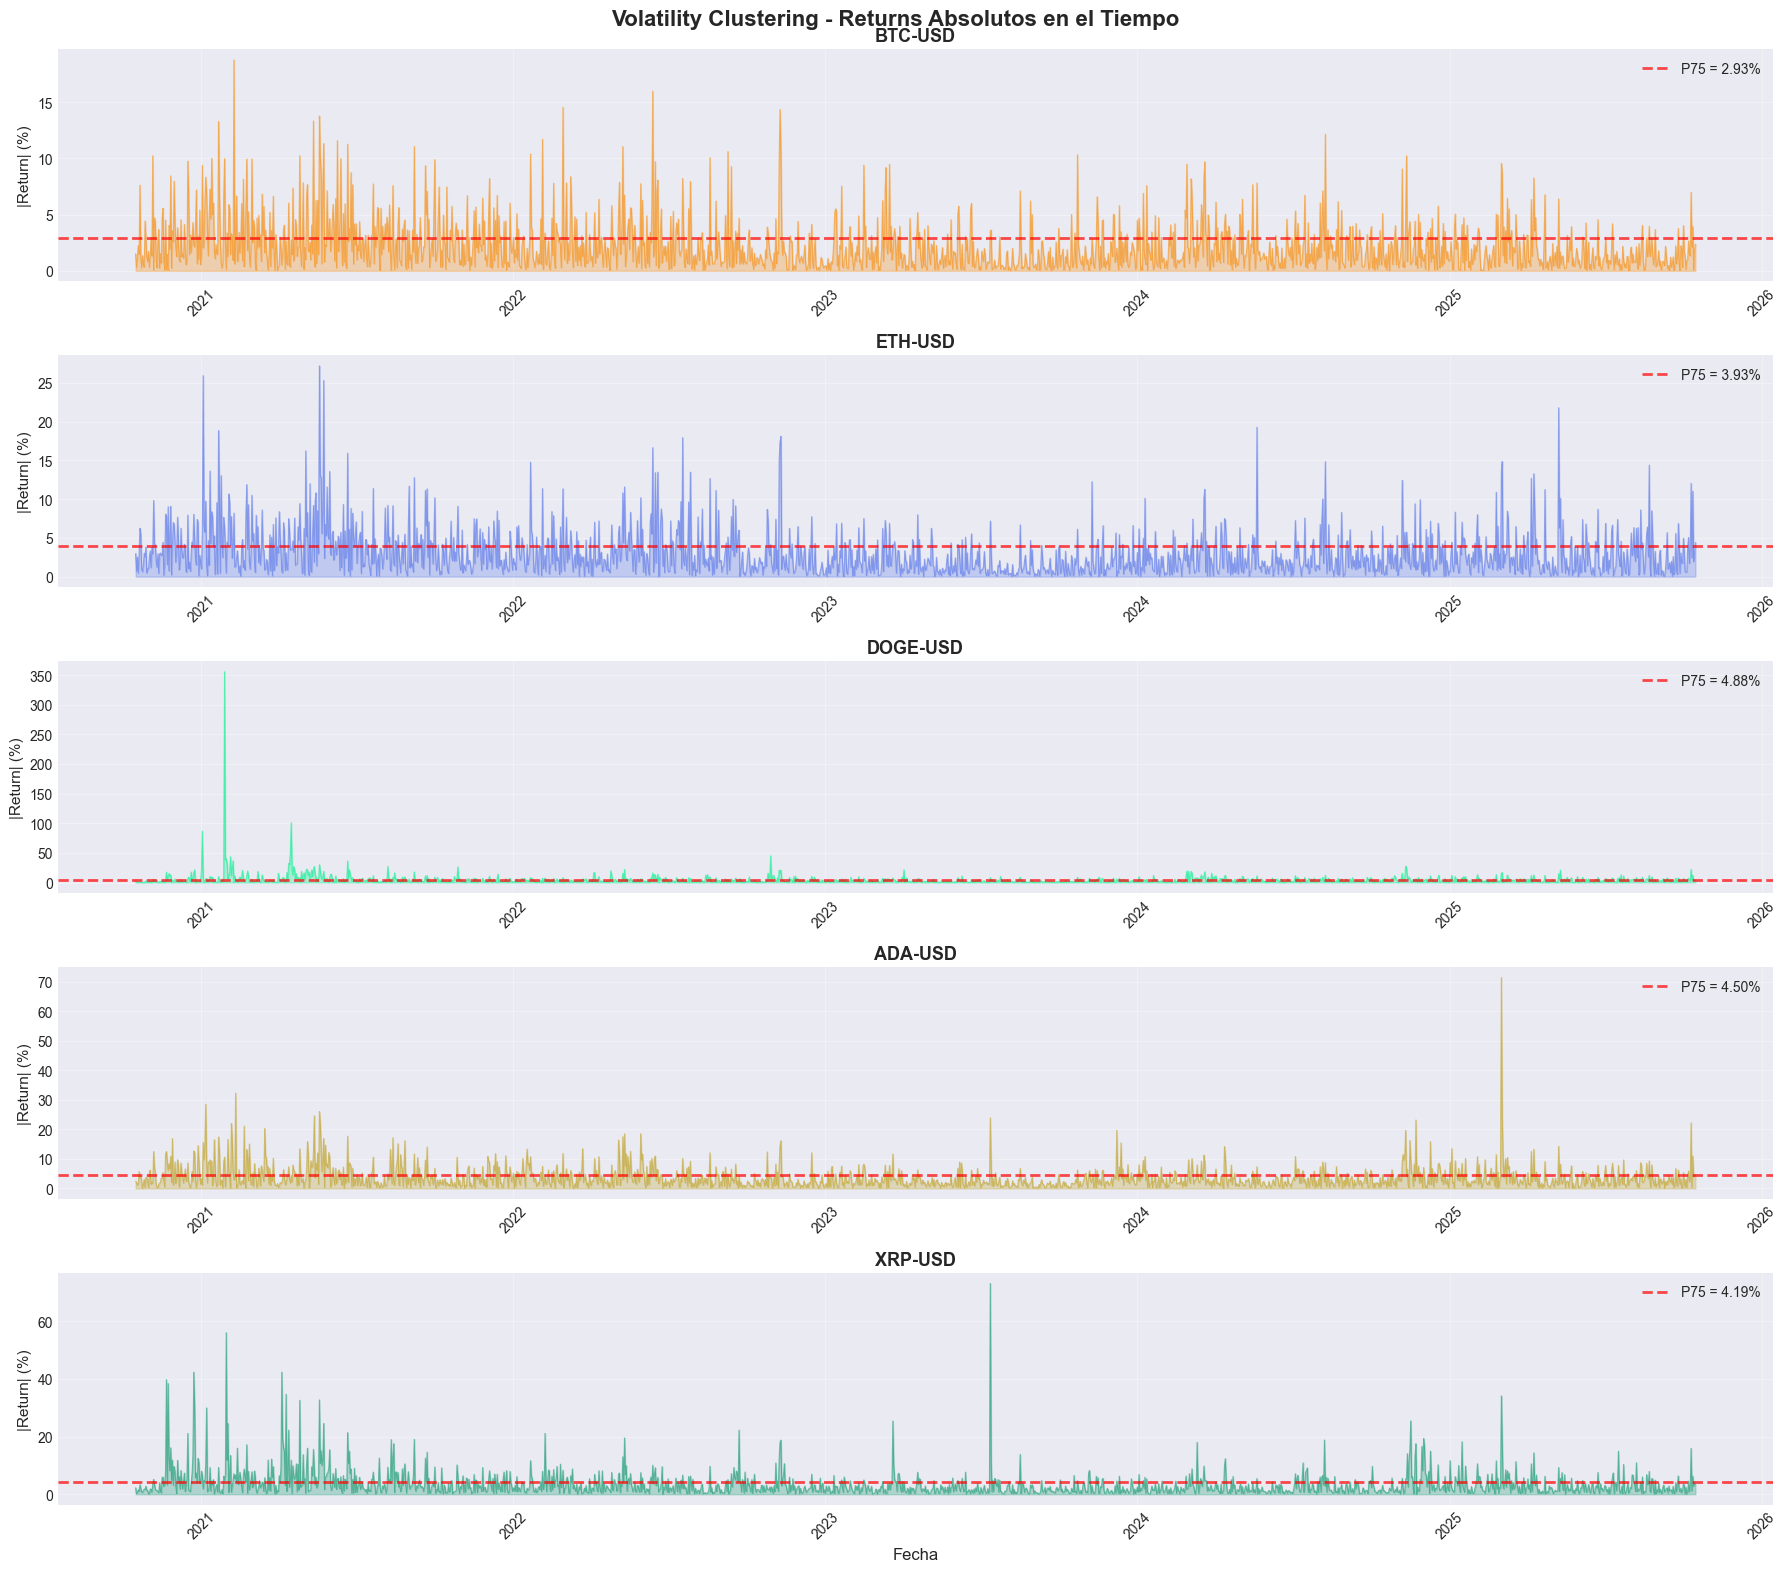


üí° INTERPRETACI√ìN:
   ‚úÖ Clustering visible: Per√≠odos de alta volatilidad se agrupan
   ‚úÖ No hay distribuci√≥n uniforme en el tiempo
   ‚úÖ Confirma hallazgos del ACF de returns¬≤


In [44]:
print("\n" + "="*80)
print("üé® VISUALIZACI√ìN DE VOLATILITY CLUSTERING")
print("="*80)

# Figura 2: Returns absolutos (proxy de volatilidad instant√°nea)
fig, axes = plt.subplots(5, 1, figsize=(18, 16))
fig.suptitle('Volatility Clustering - Returns Absolutos en el Tiempo', 
             fontsize=16, fontweight='bold')

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    returns_abs = returns_df['Simple_Return'].abs()
    
    # Plot de returns absolutos
    ax.plot(returns_df['Date'], returns_abs, color=colors[idx], 
            linewidth=0.8, alpha=0.6)
    ax.fill_between(returns_df['Date'], returns_abs, alpha=0.3, color=colors[idx])
    
    # L√≠nea de umbral (percentil 75)
    threshold = returns_abs.quantile(0.75)
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'P75 = {threshold:.2f}%')
    
    ax.set_title(f'{crypto}', fontsize=13, fontweight='bold')
    ax.set_ylabel('|Return| (%)', fontsize=11)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    if idx == 4:
        ax.set_xlabel('Fecha', fontsize=12)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nüí° INTERPRETACI√ìN:")
print("   ‚úÖ Clustering visible: Per√≠odos de alta volatilidad se agrupan")
print("   ‚úÖ No hay distribuci√≥n uniforme en el tiempo")
print("   ‚úÖ Confirma hallazgos del ACF de returns¬≤")



üìä ESTAD√çSTICAS COMPARATIVAS DE VOLATILIDAD

üìà Volatilidad Rolling 30 d√≠as - Estad√≠sticas:
  Crypto  Vol_Media  Vol_Mediana  Vol_Min   Vol_Max  Vol_Std   Coef_Var
DOGE-USD   6.543339     4.651434 1.051731 67.538135 8.630207 131.893019
 XRP-USD   4.927147     3.874155 1.583341 14.451864 3.040542  61.709999
 ADA-USD   4.728191     4.159372 1.223501 15.033164 2.301383  48.673639
 ETH-USD   3.875495     3.670327 0.805873 10.490903 1.496431  38.612630
 BTC-USD   2.922324     2.789395 0.888669  6.230881 1.058388  36.217329


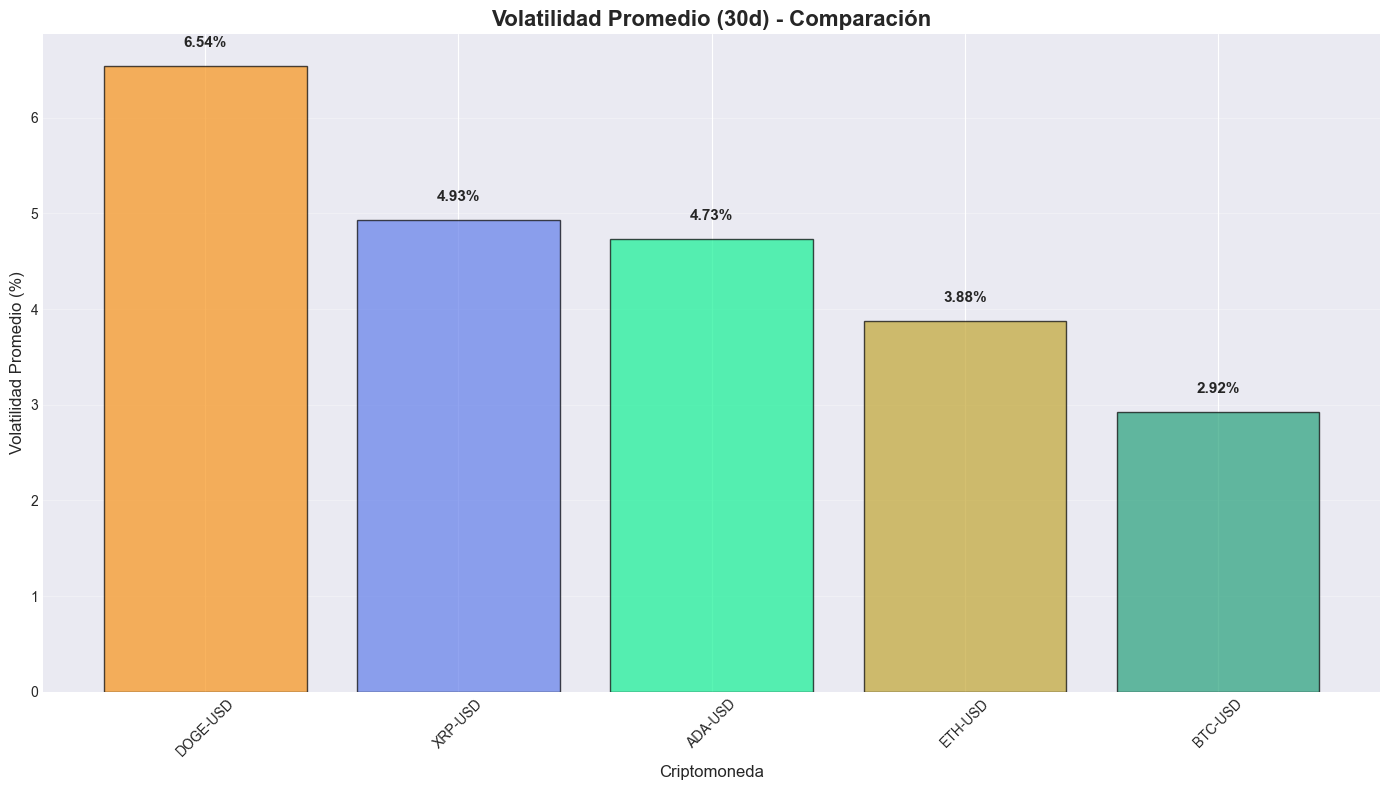

In [45]:
print("\n" + "="*80)
print("üìä ESTAD√çSTICAS COMPARATIVAS DE VOLATILIDAD")
print("="*80)

vol_stats = []

for crypto, vol_data in rolling_volatility.items():
    vol_30d = vol_data['Vol_30d'].dropna()
    
    stats = {
        'Crypto': crypto,
        'Vol_Media': vol_30d.mean(),
        'Vol_Mediana': vol_30d.median(),
        'Vol_Min': vol_30d.min(),
        'Vol_Max': vol_30d.max(),
        'Vol_Std': vol_30d.std(),
        'Coef_Var': (vol_30d.std() / vol_30d.mean()) * 100
    }
    
    vol_stats.append(stats)

vol_stats_df = pd.DataFrame(vol_stats)
vol_stats_df = vol_stats_df.sort_values('Vol_Media', ascending=False)

print("\nüìà Volatilidad Rolling 30 d√≠as - Estad√≠sticas:")
print(vol_stats_df.to_string(index=False))

# Visualizaci√≥n comparativa
fig, ax = plt.subplots(figsize=(14, 8))

cryptos = vol_stats_df['Crypto'].values
vol_means = vol_stats_df['Vol_Media'].values

bars = ax.bar(cryptos, vol_means, color=colors, alpha=0.7, edgecolor='black')

# Agregar valores en las barras
for i, (crypto, vol) in enumerate(zip(cryptos, vol_means)):
    ax.text(i, vol + 0.2, f'{vol:.2f}%', ha='center', fontsize=11, fontweight='bold')

ax.set_title('Volatilidad Promedio (30d) - Comparaci√≥n', fontsize=16, fontweight='bold')
ax.set_ylabel('Volatilidad Promedio (%)', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



üîó CORRELACI√ìN ENTRE VOLATILIDADES

üìä Matriz de Correlaci√≥n de Volatilidades:
          BTC-USD  ETH-USD  DOGE-USD  ADA-USD  XRP-USD
BTC-USD     1.000    0.821     0.502    0.645    0.522
ETH-USD     0.821    1.000     0.465    0.677    0.529
DOGE-USD    0.502    0.465     1.000    0.433    0.542
ADA-USD     0.645    0.677     0.433    1.000    0.652
XRP-USD     0.522    0.529     0.542    0.652    1.000


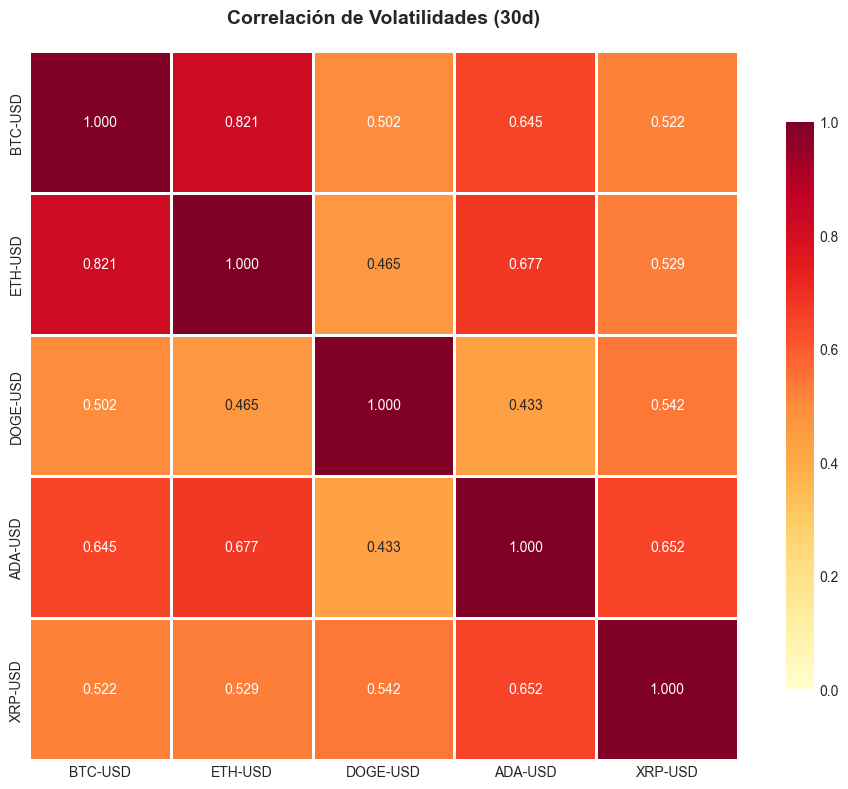


üí° INTERPRETACI√ìN:
   ‚Ä¢ Alta correlaci√≥n de volatilidades ‚Üí Shocks afectan todo el mercado
   ‚Ä¢ Per√≠odos de alta volatilidad son sist√©micos
   ‚Ä¢ Dificulta diversificaci√≥n en per√≠odos de crisis


In [46]:
print("\n" + "="*80)
print("üîó CORRELACI√ìN ENTRE VOLATILIDADES")
print("="*80)

# Crear DataFrame con volatilidades alineadas
vol_corr_df = pd.DataFrame()

for crypto, vol_data in rolling_volatility.items():
    temp = vol_data[['Date', 'Vol_30d']].copy()
    temp.columns = ['Date', crypto]
    
    if vol_corr_df.empty:
        vol_corr_df = temp
    else:
        vol_corr_df = pd.merge(vol_corr_df, temp, on='Date', how='outer')

# Calcular correlaci√≥n
vol_corr_clean = vol_corr_df.drop('Date', axis=1).dropna()
vol_correlation = vol_corr_clean.corr()

print("\nüìä Matriz de Correlaci√≥n de Volatilidades:")
print(vol_correlation.round(3))

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(vol_correlation, annot=True, cmap='YlOrRd', center=0.5, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=0, vmax=1)
plt.title('Correlaci√≥n de Volatilidades (30d)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nüí° INTERPRETACI√ìN:")
print("   ‚Ä¢ Alta correlaci√≥n de volatilidades ‚Üí Shocks afectan todo el mercado")
print("   ‚Ä¢ Per√≠odos de alta volatilidad son sist√©micos")
print("   ‚Ä¢ Dificulta diversificaci√≥n en per√≠odos de crisis")

In [47]:
print("\n" + "="*80)
print("üîî DETECCI√ìN DE EVENTOS DE ALTA VOLATILIDAD")
print("="*80)

# Detectar d√≠as con volatilidad extrema (> percentil 95)
for crypto, returns_df in crypto_returns.items():
    returns_abs = returns_df['Simple_Return'].abs()
    threshold = returns_abs.quantile(0.95)
    
    extreme_days = returns_df[returns_abs > threshold].sort_values('Simple_Return', key=abs, ascending=False)
    
    if len(extreme_days) > 0:
        print(f"\n{crypto} - Top 5 d√≠as m√°s vol√°tiles:")
        print(extreme_days[['Date', 'Simple_Return']].head(5).to_string(index=False))


üîî DETECCI√ìN DE EVENTOS DE ALTA VOLATILIDAD

BTC-USD - Top 5 d√≠as m√°s vol√°tiles:
      Date  Simple_Return
2021-02-08      18.746474
2022-06-13     -15.974726
2022-02-28      14.541184
2022-11-09     -14.349022
2021-05-19     -13.766123

ETH-USD - Top 5 d√≠as m√°s vol√°tiles:
      Date  Simple_Return
2021-05-19     -27.200349
2021-01-03      25.947533
2021-05-24      25.313630
2025-05-08      21.798769
2024-05-20      19.272223

DOGE-USD - Top 5 d√≠as m√°s vol√°tiles:
      Date  Simple_Return
2021-01-28     355.546631
2021-04-16     100.799087
2021-01-02      86.719422
2021-04-15      49.943629
2022-10-29      44.943197

ADA-USD - Top 5 d√≠as m√°s vol√°tiles:
      Date  Simple_Return
2025-03-02      71.327621
2021-02-10      32.238356
2021-01-06      28.486256
2021-05-19     -26.009428
2021-05-13      24.529825

XRP-USD - Top 5 d√≠as m√°s vol√°tiles:
      Date  Simple_Return
2023-07-13      73.075005
2021-01-30      56.010883
2020-12-23     -42.334007
2021-04-05      42.3274

In [48]:
print("\n" + "="*80)
print("üéØ RESUMEN FINAL - AN√ÅLISIS COMPLETO DE TIME SERIES")
print("="*80)

print("""
‚úÖ HALLAZGOS PRINCIPALES:

1. PRECIOS (Paso 1 & 3):
   ‚úì Son RANDOM WALKS ‚Üí No predecibles
   ‚úì Confirma Hip√≥tesis de Mercado Eficiente
   ‚úì BTC, ETH, SOL son claramente random walks
   
2. RETURNS (Paso 2 & 4):
   ‚úì Distribuci√≥n NO normal (fat tails)
   ‚úì ACF ‚âà 0 ‚Üí No autocorrelaci√≥n
   ‚úì No se puede predecir direcci√≥n futura
   
3. VOLATILIDAD (Paso 4 & 5):
   ‚úì VOLATILITY CLUSTERING presente
   ‚úì ACF de returns¬≤ > 0 ‚Üí Volatilidad predecible
   ‚úì Rolling volatility muestra per√≠odos claros
   
4. CORRELACIONES:
   ‚úì Returns correlacionados (0.3-0.8)
   ‚úì Volatilidades altamente correlacionadas (>0.6)
   ‚úì Shocks sist√©micos afectan todo el mercado

üìä RANKING DE RIESGO (Volatilidad 30d):
""")

# Mostrar ranking
for idx, row in vol_stats_df.iterrows():
    print(f"   {idx+1}. {row['Crypto']}: {row['Vol_Media']:.2f}% promedio")

print("""

üíº RECOMENDACIONES PARA INVERSIONISTAS:

‚ùå ESTRATEGIAS NO RECOMENDADAS:
   ‚Ä¢ Market timing basado solo en precios hist√≥ricos
   ‚Ä¢ Day trading sin gesti√≥n de riesgo
   ‚Ä¢ An√°lisis t√©cnico puro (sin fundamentos)
   ‚Ä¢ Ignorar per√≠odos de alta volatilidad

‚úÖ ESTRATEGIAS RECOMENDADAS:
   ‚Ä¢ Horizonte de inversi√≥n LARGO PLAZO (>1 a√±o)
   ‚Ä¢ Dollar-cost averaging (compras peri√≥dicas)
   ‚Ä¢ Diversificaci√≥n (aunque limitada dentro de crypto)
   ‚Ä¢ Gesti√≥n de riesgo DIN√ÅMICA basada en volatilidad:
     ‚Üí Reducir exposici√≥n cuando volatilidad > P75
     ‚Üí Aumentar exposici√≥n cuando volatilidad < P25
   ‚Ä¢ Stop-losses ajustados por volatilidad
   ‚Ä¢ Rebalanceo peri√≥dico de portfolio
   ‚Ä¢ Considerar an√°lisis fundamental + on-chain

üìà GESTI√ìN DE RIESGO PR√ÅCTICA:

1. MONITOREO DE VOLATILIDAD:
   ‚Ä¢ Calcular rolling volatility 30d semanalmente
   ‚Ä¢ Umbral de alerta: > percentil 75
   ‚Ä¢ Umbral de crisis: > percentil 90

2. AJUSTE DE POSICIONES:
   ‚Ä¢ Volatilidad baja ‚Üí Posici√≥n normal
   ‚Ä¢ Volatilidad alta ‚Üí Reducir 30-50%
   ‚Ä¢ Volatilidad extrema ‚Üí Liquidez defensiva

3. DIVERSIFICACI√ìN TEMPORAL:
   ‚Ä¢ No invertir todo de una vez
   ‚Ä¢ Distribuir compras en 6-12 meses
   ‚Ä¢ Aprovechar ca√≠das en per√≠odos tranquilos

üéì CONCLUSI√ìN ACAD√âMICA:

"Los mercados de criptomonedas exhiben caracter√≠sticas consistentes con la 
teor√≠a moderna de finanzas: precios como random walks (eficiencia informacional) 
pero con volatility clustering (ineficiencia de segundo momento). Esto sugiere 
que mientras la DIRECCI√ìN del precio no es predecible, el RIESGO futuro s√≠ 
puede estimarse, validando estrategias de gesti√≥n de riesgo din√°mica sobre 
estrategias de market timing."

üìö MODELOS AVANZADOS SUGERIDOS (Post-an√°lisis):
   ‚Ä¢ GARCH(1,1): Modelar volatilidad condicional
   ‚Ä¢ EGARCH: Capturar asimetr√≠as (leverage effect)
   ‚Ä¢ Copulas: Modelar dependencia conjunta en extremos
   ‚Ä¢ Jump-Diffusion: Modelar eventos extremos
   ‚Ä¢ Regime-Switching: Detectar cambios de r√©gimen
""")


üéØ RESUMEN FINAL - AN√ÅLISIS COMPLETO DE TIME SERIES

‚úÖ HALLAZGOS PRINCIPALES:

1. PRECIOS (Paso 1 & 3):
   ‚úì Son RANDOM WALKS ‚Üí No predecibles
   ‚úì Confirma Hip√≥tesis de Mercado Eficiente
   ‚úì BTC, ETH, SOL son claramente random walks

2. RETURNS (Paso 2 & 4):
   ‚úì Distribuci√≥n NO normal (fat tails)
   ‚úì ACF ‚âà 0 ‚Üí No autocorrelaci√≥n
   ‚úì No se puede predecir direcci√≥n futura

3. VOLATILIDAD (Paso 4 & 5):
   ‚úì VOLATILITY CLUSTERING presente
   ‚úì ACF de returns¬≤ > 0 ‚Üí Volatilidad predecible
   ‚úì Rolling volatility muestra per√≠odos claros

4. CORRELACIONES:
   ‚úì Returns correlacionados (0.3-0.8)
   ‚úì Volatilidades altamente correlacionadas (>0.6)
   ‚úì Shocks sist√©micos afectan todo el mercado

üìä RANKING DE RIESGO (Volatilidad 30d):

   3. DOGE-USD: 6.54% promedio
   5. XRP-USD: 4.93% promedio
   4. ADA-USD: 4.73% promedio
   2. ETH-USD: 3.88% promedio
   1. BTC-USD: 2.92% promedio


üíº RECOMENDACIONES PARA INVERSIONISTAS:

‚ùå ESTRATEGIAS 